In [33]:
# imports
import time
import math
import json
import pickle
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython import display as i_display

# plotting options
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
plt.rcParams['figure.figsize']=(23,15)


# constants
months = {'JAN':1, 'FEB':2, 'MAR':3, 'APR':4, 'MAY':5, 'JUN':6, 'JUL':7, 'AUG':8, 'SEP':9, 'OCT':10, 'NOV':11, 'DEC':12}

## <u><i>PREPROCESSING</i></u>

In [34]:
# get processed df
def get_df():
    df = pd.read_csv('problem_1.csv')
    df.head()
    
    parts = df["Booking_Date"].str.split("-", n = 3, expand = True)
    df.head()
    arr = df.to_numpy()

    # separate date of order

    # old method
    # df["year"]= parts[2].astype('int')
    # df["month"]= parts[1].astype('int')

    # new method
    df["month"] = df["Fiscal Month"].str[0:3].astype(str).map(months).astype(int)
    df["year"] = df["Fiscal Month"].str[6:].astype(int)

    df["Fiscal Month"] = df["Fiscal Month"].apply(lambda x: f'{months[x[0:3]]}-{int("20"+x[-2]+x[-1])}')
    df["Fiscal Month"] = pd.to_datetime(df["Fiscal Month"], format="%m-%Y")
    df["fiscal_date"] = df["Fiscal Month"]
    df["quarter"] = df['Fiscal Month'].dt.quarter

    # df["booking_date"] = df["Booking_Date"].astype(str)
    df["booking_date"] = pd.to_datetime(df["Booking_Date"], format="%d-%m-%Y")
    df = df.sort_values(by = "booking_date") # sort by date

    df['prod_info'] = df['Business Unit'] + df['Product Family'] + df['PLID']

    df["booked_qty"] = df["Booked_Qty"]

    # replace features with numbers
    df['business_unit'], business_unit_u = pd.factorize(df['Business Unit'])
    df['product_family'], product_family_u = pd.factorize(df['Product Family'])
    df['plid'] = df['PLID']
    # df['plid'], plid_u = pd.factorize(df['PLID'])

    # add features
    # -------------------------------------------------------------------------------------
    # feature 1 [mean change across last]
    df["mean_across_quarter"] = df.groupby(['plid', 'quarter', 'year'], as_index=False).agg({'booked_qty': 'mean'})['booked_qty']

    # feature 2 [percentage change in feature 1]
    df['percentage_mean_change'] = df.groupby(['plid', 'quarter', 'year'])['mean_across_quarter'].pct_change()

    # fill Na's
    df["mean_across_quarter"] = df["mean_across_quarter"].fillna(0)
    df["percentage_mean_change"] = df["percentage_mean_change"].fillna(0)

    feature_df = df[["mean_across_quarter","percentage_mean_change"]]
    feature_array = feature_df.to_numpy(dtype = 'float64')
    inf_array = np.isinf(feature_array)
    feature_array = np.where(inf_array, 0, feature_array)
    feature_df = pd.DataFrame(feature_array, columns = ["mean_across_quarter","percentage_mean_change"])
    # -------------------------------------------------------------------------------------
    df["mean_across_quarter"] = feature_df["mean_across_quarter"]
    df["percentage_mean_change"] = feature_df["percentage_mean_change"]
    # -------------------------------------------------------------------------------------

    df['plid'], plid_u = pd.factorize(df['PLID'])

    # print results
    print("Unique values per feature:")
    print("  Business Units:", df['business_unit'].nunique())
    print("  Product Families:", df['product_family'].nunique())
    print("  PLIDs:", df['plid'].nunique())
    print("  Years:", df['year'].nunique())
    print("  Months:", df['month'].nunique())
    print(list(df['year'].unique()))

    # store numerifications into json
    f = open("numerifications.json", 'w')
    d = {"Business Unit": {}, "Product Family": {}, "PLID": {}}

    for i, x in enumerate(business_unit_u):
        d["Business Unit"][i] = x

    for i, x in enumerate(product_family_u):
        d["Product Family"][i] = x

    for i, x in enumerate(plid_u):
        d["PLID"][i] = x

    json.dump(d, f, indent = 4)
    f.close()

    # remove old features
    df.drop('Fiscal Quarter', inplace=True, axis=1)
    df.drop('Business Unit', inplace=True, axis=1)
    df.drop('PLID', inplace=True, axis=1)
    df.drop('Fiscal Month', inplace=True, axis=1)
    df.drop('prod_info', inplace=True, axis=1)
    df.drop('Product Family', inplace=True, axis=1)
    df.drop('Booking_Date', inplace=True, axis=1)
    df.drop('Booked_Qty', inplace=True, axis=1)

    data = df.copy()
    df.head()
    
    return data

In [35]:
# load the data frame
df = get_df()
df.head()

# year from fiscal quarter | quarter number based on month | and booking date month 

Unique values per feature:
  Business Units: 18
  Product Families: 73
  PLIDs: 250
  Years: 9
  Months: 12
[2013, 2014, 2015, 2022, 2002, 2008, 2007, 2011, 2012]


month  year fiscal_date  quarter booking_date  booked_qty  \
6249      1  2013  2013-01-01        1   2013-01-01          63   
7800      1  2013  2013-01-01        1   2013-01-01       18921   
6279      2  2013  2013-02-01        1   2013-02-01          31   
7830      2  2013  2013-02-01        1   2013-02-01       12810   
6280      3  2013  2013-03-01        1   2013-03-01          61   

      business_unit  product_family  plid  mean_across_quarter  \
6249              0               0     0                  0.0   
7800              1               1     1                  0.0   
6279              0               0     0                  0.0   
7830              1               1     1                  0.0   
6280              0               0     0                 33.5   

      percentage_mean_change  
6249                     0.0  
7800                     0.0  
6279                     0.0  
7830                     0.0  
6280                     0.0

## <u><i>TRAINING [RANDOM FOREST REGRESSOR]</i></u>

In [ ]:
# imports
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# Split the data into training and test sets
train_data, test_data = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=1000, random_state=42)
features = ["mean_across_quarter", 'percentage_mean_change']

In [ ]:
rf_model.fit(train_data[features], train_data['booked_qty'])

RandomForestRegressor(n_estimators=1000, random_state=42)

In [ ]:

# Evaluate the performance of the model on the test data
test_predictions = rf_model.predict(test_data[features])
mae = mean_absolute_error(test_data['booked_qty'], test_predictions)
rmse = mean_squared_error(test_data['booked_qty'], test_predictions, squared=False)
print('MAE: {:.2f}'.format(mae))
print('RMSE: {:.2f}'.format(rmse))

MAE: 9192.67
RMSE: 18181.26


## <u><i>TRAINING [LSTM]</i></u>

In [ ]:
df.reset_index()
df.head()

month  year fiscal_date  quarter booking_date  booked_qty  business_unit  \
0      8  2022  2022-08-01        3   2016-08-01         204              0   
1     10  2022  2022-10-01        4   2016-10-01         564              0   
2      9  2022  2022-09-01        3   2016-09-01        1476              0   
3      8  2002  2002-08-01        3   2017-08-01         374              0   
4     10  2002  2002-10-01        4   2017-10-01        6094              0   

   product_family  plid  mean_across_quarter  percentage_mean_change  
0               0     0             8.666667                0.000000  
1               0     0           505.000000                0.000000  
2               0     0            12.333333                0.423077  
3               0     0            73.500000                0.000000  
4               0     0           193.500000                0.000000

<Axes: xlabel='booking_date', ylabel='booked_qty'>

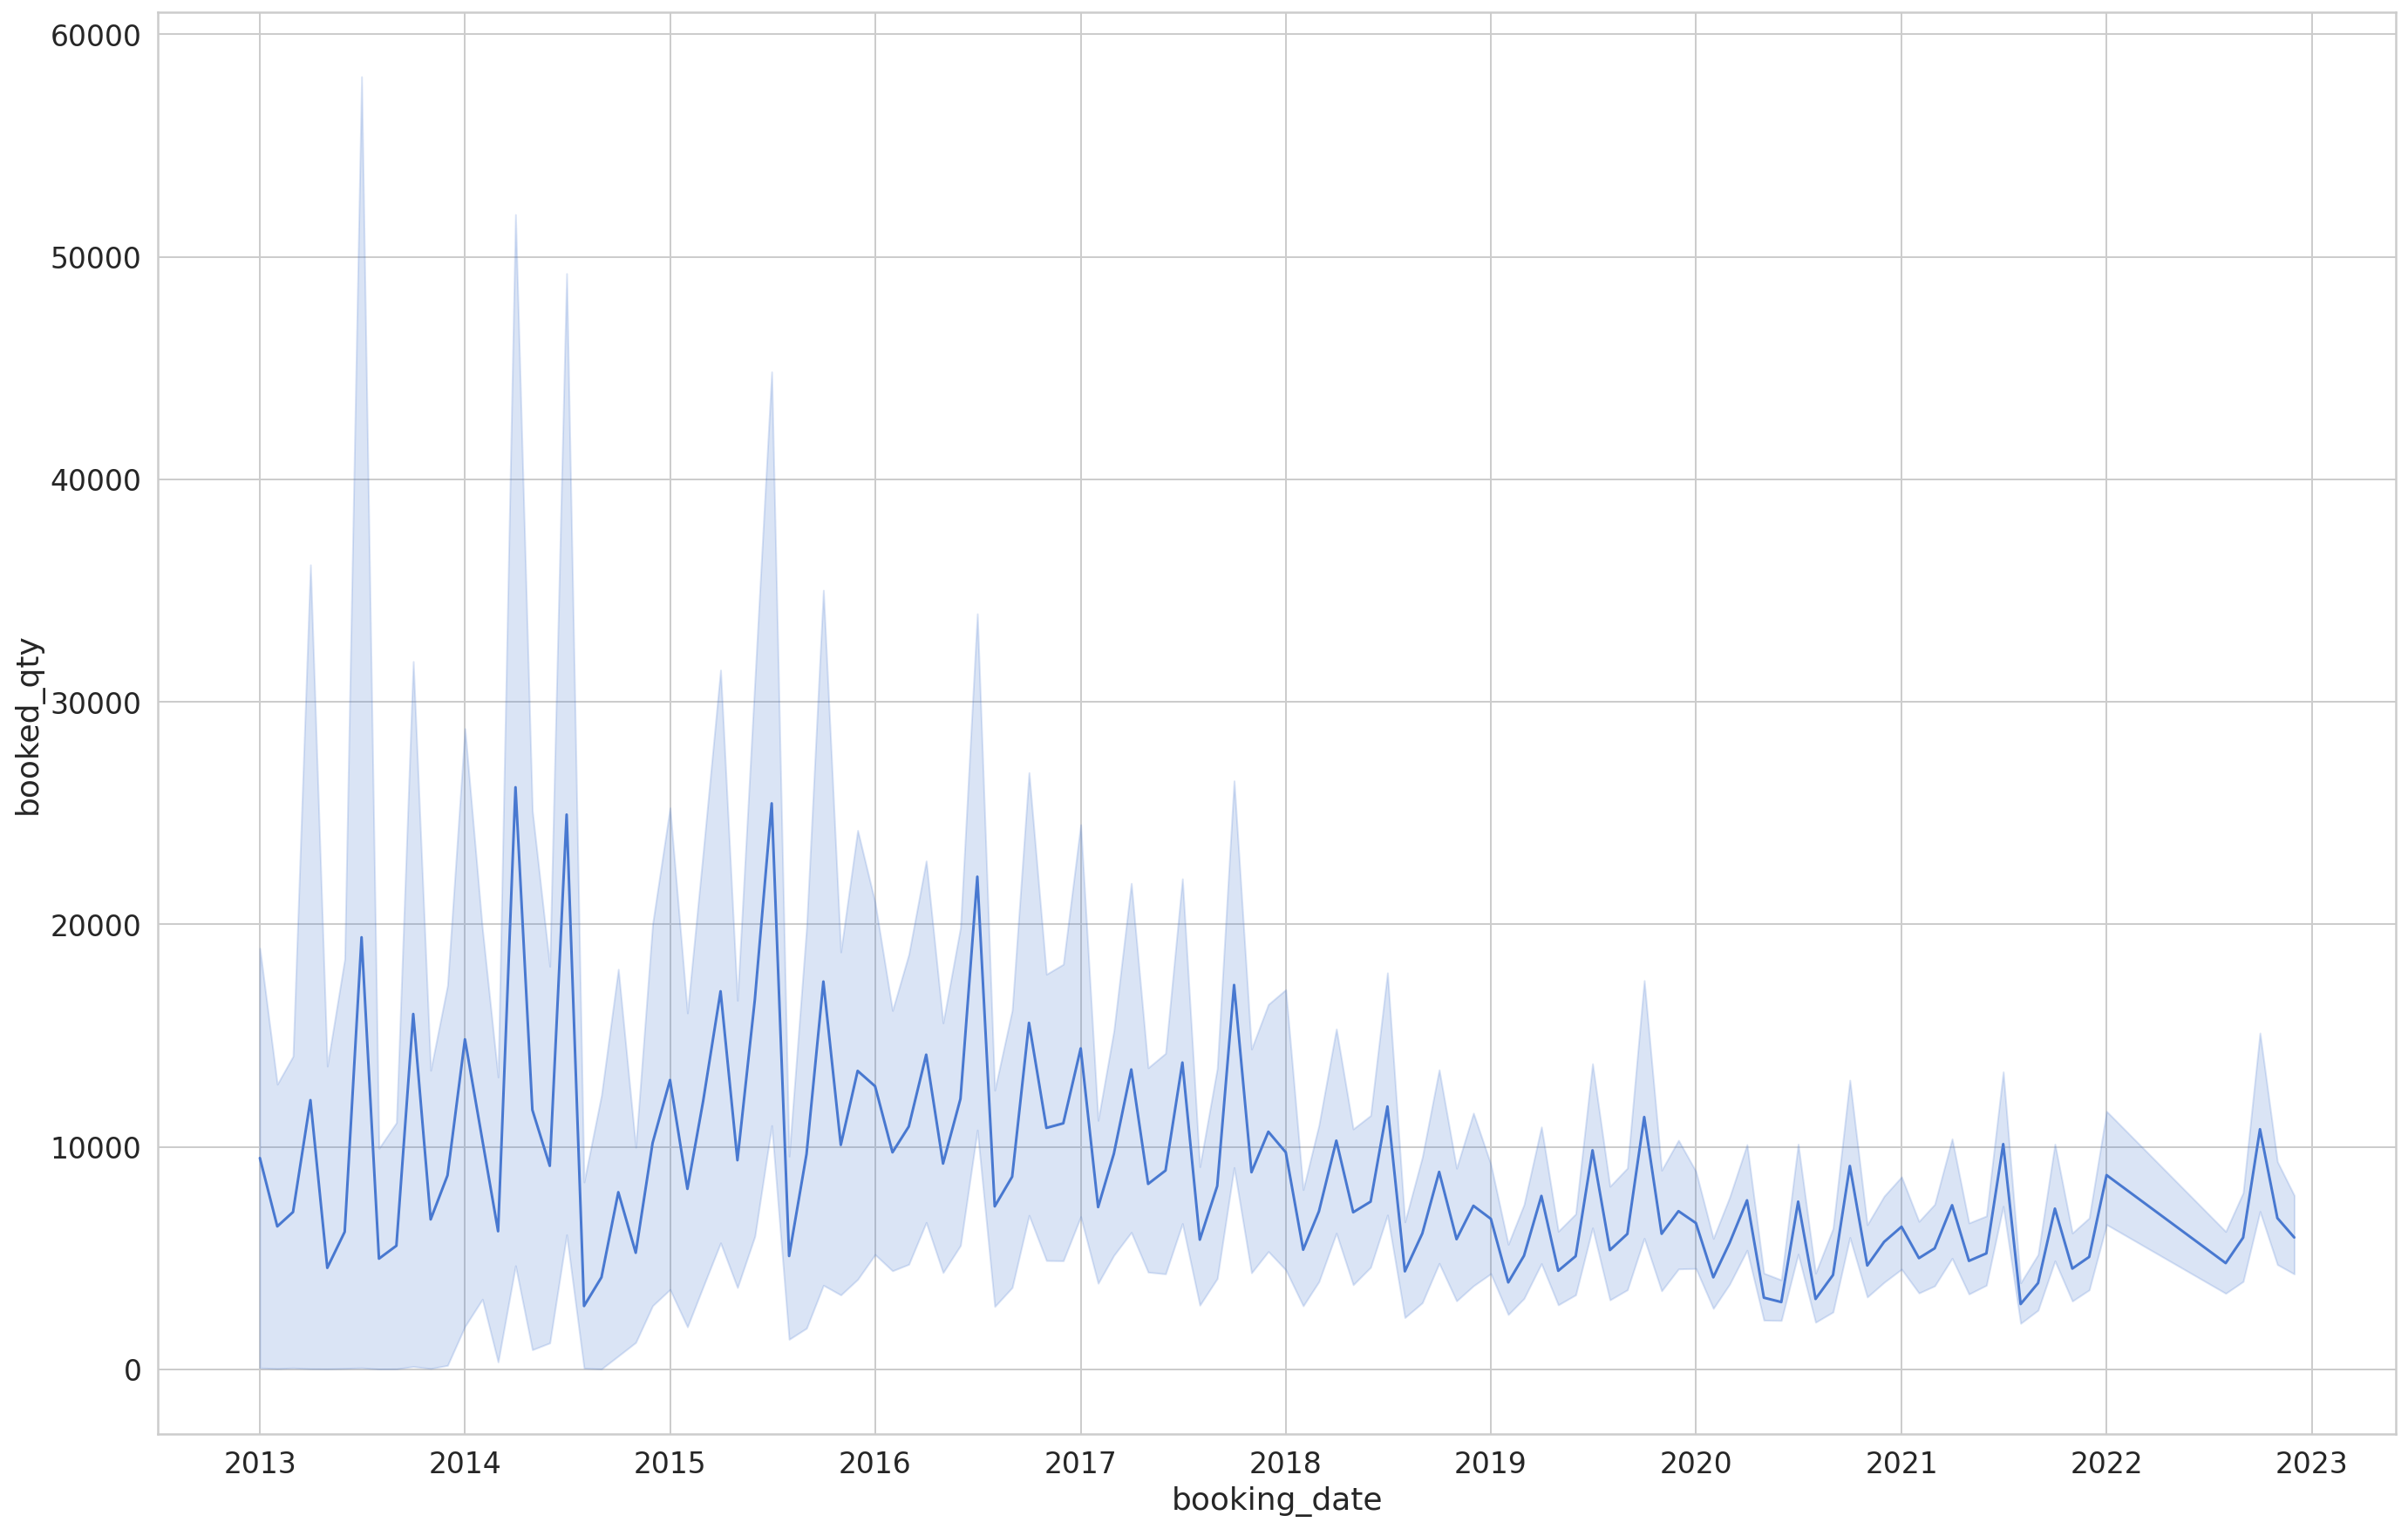

In [ ]:
sns.lineplot(x=df["booking_date"], y="booked_qty", data=df)

## <u><i>TRAINING [PROPHET]</i></u>

In [36]:
df.tail()

month  year fiscal_date  quarter booking_date  booked_qty  \
205      12  2022  2022-12-01        4   2022-12-01        3976   
8705     12  2022  2022-12-01        4   2022-12-01        9963   
7042     12  2022  2022-12-01        4   2022-12-01          76   
5405     12  2022  2022-12-01        4   2022-12-01         296   
7570     12  2022  2022-12-01        4   2022-12-01        6624   

      business_unit  product_family  plid  mean_across_quarter  \
205              17              64   188             0.000000   
8705              5              46   124             0.000000   
7042              0              41   100          1759.666667   
5405              7              40    99             0.000000   
7570              1              19   217           287.666667   

      percentage_mean_change  
205                 0.000000  
8705                0.000000  
7042                1.626368  
5405                0.000000  
7570                0.000000

In [37]:
# imports
# !pip install prophet
from prophet import Prophet
from sklearn.model_selection import train_test_split
from prophet.serialize import model_to_json, model_from_json
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
# uniques
no_products = df["plid"].nunique()
no_fams = df["product_family"].nunique()
no_business_units = df["business_unit"].nunique()
print("unique products:", no_products)
print("unique families:", no_fams)
print("unique business units:", no_business_units)

unique products: 250
unique families: 73
unique business units: 18


In [39]:
df.head()

month  year fiscal_date  quarter booking_date  booked_qty  \
6249      1  2013  2013-01-01        1   2013-01-01          63   
7800      1  2013  2013-01-01        1   2013-01-01       18921   
6279      2  2013  2013-02-01        1   2013-02-01          31   
7830      2  2013  2013-02-01        1   2013-02-01       12810   
6280      3  2013  2013-03-01        1   2013-03-01          61   

      business_unit  product_family  plid  mean_across_quarter  \
6249              0               0     0                  0.0   
7800              1               1     1                  0.0   
6279              0               0     0                  0.0   
7830              1               1     1                  0.0   
6280              0               0     0                 33.5   

      percentage_mean_change  
6249                     0.0  
7800                     0.0  
6279                     0.0  
7830                     0.0  
6280                     0.0

INFO:prophet:n_changepoints greater than number of observations. Using 90.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/13on18u4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/dve9z8q_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84539', 'data', 'file=/tmp/tmpl1hl3yn_/13on18u4.json', 'init=/tmp/tmpl1hl3yn_/dve9z8q_.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model2frg_tbz/prophet_model-20230326025239.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (344, 2)
          ds    y
0 2013-01-01   63
1 2013-02-01   31
2 2013-03-01   61
3 2013-04-01  104
4 2013-05-01   19
after mean: (114, 2)
          ds    y
0 2013-01-01   63
1 2013-02-01   31
2 2013-03-01   61
3 2013-04-01  104
4 2013-05-01   19


02:52:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: A9K1000


INFO:prophet:n_changepoints greater than number of observations. Using 90.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/c3uegz8t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ct5_i04c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45698', 'data', 'file=/tmp/tmpl1hl3yn_/c3uegz8t.json', 'init=/tmp/tmpl1hl3yn_/ct5_i04c.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model_tm30sz0/prophet_model-20230326025242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (200, 2)
          ds      y
0 2013-01-01  18921
1 2013-02-01  12810
2 2013-03-01  14069
3 2013-04-01  36158
4 2013-05-01  13622
after mean: (114, 2)
          ds      y
0 2013-01-01  18921
1 2013-02-01  12810
2 2013-03-01  14069
3 2013-04-01  36158
4 2013-05-01  13622


02:52:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: SFP10G


INFO:prophet:n_changepoints greater than number of observations. Using 83.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/eq42sc94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/uf1f7uw5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14698', 'data', 'file=/tmp/tmpl1hl3yn_/eq42sc94.json', 'init=/tmp/tmpl1hl3yn_/uf1f7uw5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modela0shy8ox/prophet_model-20230326025247.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (199, 2)
          ds    y
0 2013-04-01   25
1 2013-05-01   27
2 2013-06-01   38
3 2013-07-01   77
4 2014-01-01  315
after mean: (106, 2)
          ds    y
0 2013-04-01   25
1 2013-05-01   27
2 2013-06-01   38
3 2013-07-01   77
4 2014-01-01  315


02:52:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: ISR1121


INFO:prophet:n_changepoints greater than number of observations. Using 81.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/q8xcqd1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/b2j2_wg5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45467', 'data', 'file=/tmp/tmpl1hl3yn_/q8xcqd1b.json', 'init=/tmp/tmpl1hl3yn_/b2j2_wg5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeleejobn5_/prophet_model-20230326025251.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:52:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (103, 2)
          ds    y
0 2013-07-01   87
1 2014-01-01  387
2 2014-02-01  536
3 2014-03-01  298
4 2014-04-01  904
after mean: (103, 2)
          ds    y
0 2013-07-01   87
1 2014-01-01  387
2 2014-02-01  536
3 2014-03-01  298
4 2014-04-01  904


02:52:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CPAK100


INFO:prophet:n_changepoints greater than number of observations. Using 77.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/fmkcyrsm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/pxhufco8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41876', 'data', 'file=/tmp/tmpl1hl3yn_/fmkcyrsm.json', 'init=/tmp/tmpl1hl3yn_/pxhufco8.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model5jrs7whe/prophet_model-20230326025254.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:52:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (98, 2)
          ds      y
0 2014-01-01   4729
1 2014-02-01   2366
2 2014-03-01   4569
3 2014-04-01  13293
4 2014-05-01   4368
after mean: (98, 2)
          ds      y
0 2014-01-01   4729
1 2014-02-01   2366
2 2014-03-01   4569
3 2014-04-01  13293
4 2014-05-01   4368


02:53:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: QSFP40G


INFO:prophet:n_changepoints greater than number of observations. Using 79.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/amr50s_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/4gnww8iz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31321', 'data', 'file=/tmp/tmpl1hl3yn_/amr50s_a.json', 'init=/tmp/tmpl1hl3yn_/4gnww8iz.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model40cali6p/prophet_model-20230326025320.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (572, 2)
          ds      y
0 2014-01-01  53377
1 2014-01-01  31729
2 2014-02-01  28942
3 2014-02-01  28693
4 2014-03-01      0
after mean: (100, 2)
          ds       y
0 2014-01-01   85106
1 2014-02-01   57635
2 2014-03-01   83759
3 2014-04-01  177619
4 2014-05-01  126147


02:53:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: PHONVOC


INFO:prophet:n_changepoints greater than number of observations. Using 79.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/uvhzvm98.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/rvt5g8_a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92762', 'data', 'file=/tmp/tmpl1hl3yn_/uvhzvm98.json', 'init=/tmp/tmpl1hl3yn_/rvt5g8_a.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model0cwzu2a7/prophet_model-20230326025323.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:53:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:53:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


before mean: (290, 2)
          ds    y
0 2014-01-01   91
1 2014-02-01   29
2 2014-03-01   32
3 2014-04-01  112
4 2014-05-01   24
after mean: (101, 2)
          ds    y
0 2014-01-01   91
1 2014-02-01   29
2 2014-03-01   32
3 2014-04-01  112
4 2014-05-01   24
Family Name: N9500


INFO:prophet:n_changepoints greater than number of observations. Using 75.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/8nht2v7w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ayrbcqha.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57637', 'data', 'file=/tmp/tmpl1hl3yn_/8nht2v7w.json', 'init=/tmp/tmpl1hl3yn_/ayrbcqha.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelcou9i5or/prophet_model-20230326025325.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:53:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (366, 2)
          ds     y
0 2014-03-01     5
1 2014-04-01   319
2 2014-05-01   387
3 2014-06-01   627
4 2014-07-01  1116
after mean: (95, 2)
          ds     y
0 2014-03-01     5
1 2014-04-01   319
2 2014-05-01   387
3 2014-06-01   627
4 2014-07-01  1116


02:53:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CTSQS


INFO:prophet:n_changepoints greater than number of observations. Using 73.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/dhf5uw6h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/42c8t0r1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63248', 'data', 'file=/tmp/tmpl1hl3yn_/dhf5uw6h.json', 'init=/tmp/tmpl1hl3yn_/42c8t0r1.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelfp9xzo8x/prophet_model-20230326025339.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:53:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (278, 2)
          ds  y
0 2014-03-01  0
1 2014-03-01  0
2 2014-06-01  1
3 2014-06-01  1
4 2014-06-01  2
after mean: (93, 2)
          ds     y
0 2014-03-01     0
1 2014-06-01     4
2 2014-07-01     7
3 2015-01-01  2541
4 2015-02-01  3948


02:53:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: 4300ISR


INFO:prophet:n_changepoints greater than number of observations. Using 68.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/vac2eu99.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/kpzlh_zs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34947', 'data', 'file=/tmp/tmpl1hl3yn_/vac2eu99.json', 'init=/tmp/tmpl1hl3yn_/kpzlh_zs.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model2ag3syip/prophet_model-20230326025354.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:53:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (87, 2)
          ds    y
0 2014-03-01    0
1 2015-01-01    2
2 2015-02-01  126
3 2015-03-01  450
4 2015-04-01  674
after mean: (87, 2)
          ds    y
0 2014-03-01    0
1 2015-01-01    2
2 2015-02-01  126
3 2015-03-01  450
4 2015-04-01  674


02:53:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C3560CX


INFO:prophet:n_changepoints greater than number of observations. Using 67.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/93hjr8mm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/lfv2mfbf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73808', 'data', 'file=/tmp/tmpl1hl3yn_/93hjr8mm.json', 'init=/tmp/tmpl1hl3yn_/lfv2mfbf.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model94h2t_h4/prophet_model-20230326025359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:53:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (252, 2)
          ds   y
0 2015-01-01  41
1 2015-01-01  11
2 2015-02-01  49
3 2015-02-01  14
4 2015-03-01  53
after mean: (85, 2)
          ds    y
0 2015-01-01   52
1 2015-02-01   63
2 2015-03-01  131
3 2015-04-01  120
4 2015-05-01   21


02:54:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: A9K9KFM


INFO:prophet:n_changepoints greater than number of observations. Using 71.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/coeripm9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/uei410hs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39668', 'data', 'file=/tmp/tmpl1hl3yn_/coeripm9.json', 'init=/tmp/tmpl1hl3yn_/uei410hs.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model37n4_msb/prophet_model-20230326025407.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (258, 2)
          ds    y
0 2015-01-01  179
1 2015-01-01   79
2 2015-02-01  397
3 2015-02-01   11
4 2015-03-01   26
after mean: (90, 2)
          ds    y
0 2015-01-01  258
1 2015-02-01  408
2 2015-03-01  381
3 2015-04-01  311
4 2015-05-01  217


02:54:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: A9K920


INFO:prophet:n_changepoints greater than number of observations. Using 67.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/lc3dxcsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/jwku3mlz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8339', 'data', 'file=/tmp/tmpl1hl3yn_/lc3dxcsh.json', 'init=/tmp/tmpl1hl3yn_/jwku3mlz.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelw7fribu1/prophet_model-20230326025416.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (85, 2)
          ds   y
0 2015-01-01  44
1 2015-02-01  20
2 2015-03-01   2
3 2015-04-01  62
4 2015-05-01   4
after mean: (85, 2)
          ds   y
0 2015-01-01  44
1 2015-02-01  20
2 2015-03-01   2
3 2015-04-01  62
4 2015-05-01   4


02:54:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: SFPGE


INFO:prophet:n_changepoints greater than number of observations. Using 66.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/bmkj7p6p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/tm9itq1x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59268', 'data', 'file=/tmp/tmpl1hl3yn_/bmkj7p6p.json', 'init=/tmp/tmpl1hl3yn_/tm9itq1x.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model7g8m5qtn/prophet_model-20230326025422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (149, 2)
          ds   y
0 2015-02-01  30
1 2015-03-01   5
2 2015-04-01   4
3 2015-05-01   1
4 2015-06-01   7
after mean: (84, 2)
          ds   y
0 2015-02-01  30
1 2015-03-01   5
2 2015-04-01   4
3 2015-05-01   1
4 2015-06-01   7


02:54:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: IE4000


INFO:prophet:n_changepoints greater than number of observations. Using 64.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/5km6rn1j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/o1bepd3g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48713', 'data', 'file=/tmp/tmpl1hl3yn_/5km6rn1j.json', 'init=/tmp/tmpl1hl3yn_/o1bepd3g.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelev6sy0mk/prophet_model-20230326025429.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (236, 2)
          ds    y
0 2015-04-01   63
1 2015-05-01    3
2 2015-06-01  222
3 2015-07-01   26
4 2016-01-01  190
after mean: (82, 2)
          ds    y
0 2015-04-01   63
1 2015-05-01    3
2 2015-06-01  222
3 2015-07-01   26
4 2016-01-01  190


02:54:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: A9K9000


INFO:prophet:n_changepoints greater than number of observations. Using 64.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/0tvgfj3s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/k1s4lwe3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83592', 'data', 'file=/tmp/tmpl1hl3yn_/0tvgfj3s.json', 'init=/tmp/tmpl1hl3yn_/k1s4lwe3.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model0moe10f0/prophet_model-20230326025436.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (267, 2)
          ds   y
0 2015-04-01  19
1 2015-05-01   2
2 2015-05-01   2
3 2015-06-01  39
4 2015-06-01  38
after mean: (82, 2)
          ds    y
0 2015-04-01   19
1 2015-05-01    4
2 2015-06-01   77
3 2015-07-01  185
4 2016-01-01   43


02:54:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: 15454W


INFO:prophet:n_changepoints greater than number of observations. Using 62.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/rb5iknpw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/qx5h62xj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=73922', 'data', 'file=/tmp/tmpl1hl3yn_/rb5iknpw.json', 'init=/tmp/tmpl1hl3yn_/qx5h62xj.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeld14smo5o/prophet_model-20230326025446.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:46 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (79, 2)
          ds    y
0 2015-07-01   14
1 2016-01-01   57
2 2016-02-01    8
3 2016-03-01   93
4 2016-04-01  117
after mean: (79, 2)
          ds    y
0 2015-07-01   14
1 2016-01-01   57
2 2016-02-01    8
3 2016-03-01   93
4 2016-04-01  117


02:54:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: ONS


INFO:prophet:n_changepoints greater than number of observations. Using 62.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/faci86s9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/a0573fy2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66728', 'data', 'file=/tmp/tmpl1hl3yn_/faci86s9.json', 'init=/tmp/tmpl1hl3yn_/a0573fy2.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model7vz33p5e/prophet_model-20230326025449.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (151, 2)
          ds     y
0 2015-07-01  2092
1 2016-01-01  2576
2 2016-02-01   473
3 2016-02-01  3562
4 2016-03-01   181
after mean: (79, 2)
          ds     y
0 2015-07-01  2092
1 2016-01-01  2576
2 2016-02-01  4035
3 2016-03-01  1339
4 2016-04-01  6330


02:54:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CBR8


INFO:prophet:n_changepoints greater than number of observations. Using 62.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1tuwas5r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/785vq4ly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87880', 'data', 'file=/tmp/tmpl1hl3yn_/1tuwas5r.json', 'init=/tmp/tmpl1hl3yn_/785vq4ly.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model62o7jrme/prophet_model-20230326025455.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:54:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (158, 2)
          ds      y
0 2015-07-01   1505
1 2015-07-01  19030
2 2016-01-01  15710
3 2016-01-01   2855
4 2016-02-01  11631
after mean: (79, 2)
          ds      y
0 2015-07-01  20535
1 2016-01-01  18565
2 2016-02-01  18088
3 2016-03-01  37302
4 2016-04-01  29166


02:55:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: PHONVID


INFO:prophet:n_changepoints greater than number of observations. Using 58.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/7hxn8ko8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/uqnuyt9h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96224', 'data', 'file=/tmp/tmpl1hl3yn_/7hxn8ko8.json', 'init=/tmp/tmpl1hl3yn_/uqnuyt9h.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelmu86c_9n/prophet_model-20230326025502.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (401, 2)
          ds   y
0 2016-01-01  19
1 2016-02-01  30
2 2016-02-01   0
3 2016-03-01  28
4 2016-03-01   0
after mean: (74, 2)
          ds    y
0 2016-01-01   19
1 2016-02-01   30
2 2016-03-01   28
3 2016-04-01  232
4 2016-05-01  605


02:55:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: QSFP100


INFO:prophet:n_changepoints greater than number of observations. Using 58.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/xan5f2ny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/99uj30dw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34519', 'data', 'file=/tmp/tmpl1hl3yn_/xan5f2ny.json', 'init=/tmp/tmpl1hl3yn_/99uj30dw.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelq4rboizs/prophet_model-20230326025509.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (261, 2)
          ds   y
0 2016-01-01   1
1 2016-02-01   1
2 2016-03-01   0
3 2016-04-01  12
4 2016-05-01   9
after mean: (74, 2)
          ds   y
0 2016-01-01   1
1 2016-02-01   1
2 2016-03-01   0
3 2016-04-01  12
4 2016-05-01   9


02:55:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS5500


/usr/local/lib/python3.9/dist-packages/prophet/plot.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(facecolor='w', figsize=figsize)
INFO:prophet:n_changepoints greater than number of observations. Using 56.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ze2abvem.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/l_2w7a75.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=67201', 'data', 'file=/tmp/tmpl1hl3yn_/ze2abvem.json', 'init=/tmp/tmpl1hl3yn_/l_2w7a75.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeltmx3g_ow/prophet_model-20230326025515

before mean: (118, 2)
          ds   y
0 2016-02-01   0
1 2016-03-01   3
2 2016-04-01  11
3 2016-05-01  11
4 2016-06-01  14
after mean: (72, 2)
          ds   y
0 2016-02-01   0
1 2016-03-01   3
2 2016-04-01  11
3 2016-05-01  11
4 2016-06-01  14


02:55:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: PHON3PC


INFO:prophet:n_changepoints greater than number of observations. Using 49.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/f1_9uqdc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/p0938tt7.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28255', 'data', 'file=/tmp/tmpl1hl3yn_/f1_9uqdc.json', 'init=/tmp/tmpl1hl3yn_/p0938tt7.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model40k7uv_q/prophet_model-20230326025521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (63, 2)
          ds  y
0 2016-03-01  0
1 2016-06-01  0
2 2016-07-01  1
3 2017-01-01  0
4 2017-02-01  0
after mean: (63, 2)
          ds  y
0 2016-03-01  0
1 2016-06-01  0
2 2016-07-01  1
3 2017-01-01  0
4 2017-02-01  0


02:55:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS4200


INFO:prophet:n_changepoints greater than number of observations. Using 55.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/c4m_xtnu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/67bjeam5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=15022', 'data', 'file=/tmp/tmpl1hl3yn_/c4m_xtnu.json', 'init=/tmp/tmpl1hl3yn_/67bjeam5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model0tw7_7f_/prophet_model-20230326025525.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (70, 2)
          ds     y
0 2016-04-01   115
1 2016-05-01    66
2 2016-06-01   210
3 2016-07-01  1100
4 2017-01-01   594
after mean: (70, 2)
          ds     y
0 2016-04-01   115
1 2016-05-01    66
2 2016-06-01   210
3 2016-07-01  1100
4 2017-01-01   594


02:55:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C3650


INFO:prophet:n_changepoints greater than number of observations. Using 54.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/9cqx6f9p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/sre2wcy9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37961', 'data', 'file=/tmp/tmpl1hl3yn_/9cqx6f9p.json', 'init=/tmp/tmpl1hl3yn_/sre2wcy9.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelxnmb9r3m/prophet_model-20230326025529.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (69, 2)
          ds     y
0 2016-05-01     2
1 2016-06-01     0
2 2016-07-01  8208
3 2017-01-01  9965
4 2017-02-01  9544
after mean: (69, 2)
          ds     y
0 2016-05-01     2
1 2016-06-01     0
2 2016-07-01  8208
3 2017-01-01  9965
4 2017-02-01  9544


INFO:cmdstanpy:Chain [1] done processing


Family Name: WPHONE


INFO:prophet:n_changepoints greater than number of observations. Using 47.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/j2v5zfgy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/x3yvmfbm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=28139', 'data', 'file=/tmp/tmpl1hl3yn_/j2v5zfgy.json', 'init=/tmp/tmpl1hl3yn_/x3yvmfbm.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeliqcetd6f/prophet_model-20230326025536.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (118, 2)
          ds   y
0 2017-01-01   4
1 2017-02-01  14
2 2017-03-01   1
3 2017-04-01   4
4 2017-05-01   7
after mean: (61, 2)
          ds   y
0 2017-01-01   4
1 2017-02-01  14
2 2017-03-01   1
3 2017-04-01   4
4 2017-05-01   7


02:55:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS1000
before mean: (66, 2)
          ds    y
0 2017-01-01   34
1 2017-02-01   73
2 2017-03-01   86
3 2017-04-01  342
4 2017-05-01  190
after mean: (66, 2)
          ds    y
0 2017-01-01   34
1 2017-02-01   73
2 2017-03-01   86
3 2017-04-01  342
4 2017-05-01  190


INFO:prophet:n_changepoints greater than number of observations. Using 51.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/qjv23u81.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/8kgzcliu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46671', 'data', 'file=/tmp/tmpl1hl3yn_/qjv23u81.json', 'init=/tmp/tmpl1hl3yn_/8kgzcliu.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelx7e36hkg/prophet_model-20230326025541.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:55:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: WANLAN


INFO:prophet:n_changepoints greater than number of observations. Using 45.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/jjiefjba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/mrwl4t1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22206', 'data', 'file=/tmp/tmpl1hl3yn_/jjiefjba.json', 'init=/tmp/tmpl1hl3yn_/mrwl4t1d.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model02zrg9ud/prophet_model-20230326025545.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:55:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (414, 2)
          ds    y
0 2017-04-01    5
1 2017-05-01   35
2 2017-06-01   16
3 2017-07-01  831
4 2017-07-01   68
after mean: (58, 2)
          ds     y
0 2017-04-01     5
1 2017-05-01    35
2 2017-06-01    16
3 2017-07-01   961
4 2018-01-01  2810


02:57:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: N9300


INFO:prophet:n_changepoints greater than number of observations. Using 45.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/x4famz6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/aqvewbyd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70409', 'data', 'file=/tmp/tmpl1hl3yn_/x4famz6v.json', 'init=/tmp/tmpl1hl3yn_/aqvewbyd.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model51fnfll6/prophet_model-20230326025706.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:57:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (204, 2)
          ds     y
0 2017-04-01   322
1 2017-04-01   726
2 2017-05-01    62
3 2017-05-01  1906
4 2017-06-01  7289
after mean: (58, 2)
          ds     y
0 2017-04-01  1048
1 2017-05-01  1968
2 2017-06-01  7824
3 2017-07-01   508
4 2018-01-01  2047


02:57:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: MDS9000


INFO:prophet:n_changepoints greater than number of observations. Using 44.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ktspw237.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/dwmx6xmb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45703', 'data', 'file=/tmp/tmpl1hl3yn_/ktspw237.json', 'init=/tmp/tmpl1hl3yn_/dwmx6xmb.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model7ttrnq5i/prophet_model-20230326025711.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:57:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (57, 2)
          ds   y
0 2017-05-01   2
1 2017-06-01   8
2 2017-07-01  24
3 2018-01-01  44
4 2018-02-01  10
after mean: (57, 2)
          ds   y
0 2017-05-01   2
1 2017-06-01   8
2 2017-07-01  24
3 2018-01-01  44
4 2018-02-01  10


02:57:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS6000


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/10vzytvt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/3672ekv4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25810', 'data', 'file=/tmp/tmpl1hl3yn_/10vzytvt.json', 'init=/tmp/tmpl1hl3yn_/3672ekv4.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modele7fx5tg3/prophet_model-20230326025714.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:57:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (458, 2)
          ds    y
0 2017-06-01  148
1 2017-06-01   42
2 2017-06-01   41
3 2017-06-01  151
4 2017-06-01   32
after mean: (56, 2)
          ds      y
0 2017-06-01    414
1 2017-07-01   7465
2 2018-01-01  29211
3 2018-02-01  16245
4 2018-03-01  22887


02:57:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9300


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ncsvpopc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/q3msie6i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64377', 'data', 'file=/tmp/tmpl1hl3yn_/ncsvpopc.json', 'init=/tmp/tmpl1hl3yn_/q3msie6i.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelme5x0ape/prophet_model-20230326025720.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:57:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (122, 2)
          ds    y
0 2017-06-01    8
1 2017-06-01    8
2 2017-07-01  376
3 2017-07-01  316
4 2018-01-01  725
after mean: (56, 2)
          ds     y
0 2017-06-01    16
1 2017-07-01   692
2 2018-01-01  2648
3 2018-02-01  1385
4 2018-03-01  1688


02:58:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSC


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/xcjk281x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/uhdkokmh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86422', 'data', 'file=/tmp/tmpl1hl3yn_/xcjk281x.json', 'init=/tmp/tmpl1hl3yn_/uhdkokmh.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeluc7vgo40/prophet_model-20230326025834.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:58:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (100, 2)
          ds     y
0 2017-06-01    73
1 2017-07-01  1582
2 2018-01-01  4292
3 2018-02-01  3487
4 2018-03-01  4405
after mean: (56, 2)
          ds     y
0 2017-06-01    73
1 2017-07-01  1582
2 2018-01-01  4292
3 2018-02-01  3487
4 2018-03-01  4405


02:58:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSB


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/49210jl3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/nglg5817.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49028', 'data', 'file=/tmp/tmpl1hl3yn_/49210jl3.json', 'init=/tmp/tmpl1hl3yn_/nglg5817.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelftgt4xmw/prophet_model-20230326025837.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:58:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (424, 2)
          ds     y
0 2017-07-01  1612
1 2017-07-01    88
2 2017-07-01    58
3 2017-07-01     5
4 2017-07-01   548
after mean: (55, 2)
          ds      y
0 2017-07-01   3767
1 2018-01-01  13430
2 2018-02-01   7128
3 2018-03-01  16277
4 2018-04-01  25196


02:58:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9400


INFO:prophet:n_changepoints greater than number of observations. Using 41.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/mal1e4z0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/srwscls2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=56377', 'data', 'file=/tmp/tmpl1hl3yn_/mal1e4z0.json', 'init=/tmp/tmpl1hl3yn_/srwscls2.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelqemfru1_/prophet_model-20230326025840.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (53, 2)
          ds     y
0 2017-07-01   154
1 2018-01-01  1669
2 2018-02-01  1418
3 2018-03-01   683
4 2018-04-01  2617
after mean: (53, 2)
          ds     y
0 2017-07-01   154
1 2018-01-01  1669
2 2018-02-01  1418
3 2018-03-01   683
4 2018-04-01  2617


02:58:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: HXSSD


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/imnanuub.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/tnmy_47d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8735', 'data', 'file=/tmp/tmpl1hl3yn_/imnanuub.json', 'init=/tmp/tmpl1hl3yn_/tnmy_47d.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelwluv73z_/prophet_model-20230326025843.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:58:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (55, 2)
          ds     y
0 2017-07-01   475
1 2018-01-01   474
2 2018-02-01   517
3 2018-03-01   603
4 2018-04-01  1277
after mean: (55, 2)
          ds     y
0 2017-07-01   475
1 2018-01-01   474
2 2018-02-01   517
3 2018-03-01   603
4 2018-04-01  1277


02:58:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSSSD


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/hp3gtpxz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/_u_z0qo8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96658', 'data', 'file=/tmp/tmpl1hl3yn_/hp3gtpxz.json', 'init=/tmp/tmpl1hl3yn_/_u_z0qo8.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelha8o802c/prophet_model-20230326025847.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (325, 2)
          ds     y
0 2017-07-01     0
1 2017-07-01   244
2 2018-01-01  3243
3 2018-01-01   184
4 2018-02-01   557
after mean: (55, 2)
          ds     y
0 2017-07-01   244
1 2018-01-01  3427
2 2018-02-01  3861
3 2018-03-01  8403
4 2018-04-01  6584


02:59:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSMEM


INFO:prophet:n_changepoints greater than number of observations. Using 43.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/zmtr69hm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/mjgnnztf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55672', 'data', 'file=/tmp/tmpl1hl3yn_/zmtr69hm.json', 'init=/tmp/tmpl1hl3yn_/mjgnnztf.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeld_e2pl_w/prophet_model-20230326025907.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (193, 2)
          ds    y
0 2017-07-01  162
1 2018-01-01  827
2 2018-02-01  788
3 2018-03-01  995
4 2018-04-01   18
after mean: (55, 2)
          ds     y
0 2017-07-01   162
1 2018-01-01   827
2 2018-02-01   788
3 2018-03-01   995
4 2018-04-01  1432


02:59:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9500


INFO:prophet:n_changepoints greater than number of observations. Using 41.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/p878edeh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1a4nmp1d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92784', 'data', 'file=/tmp/tmpl1hl3yn_/p878edeh.json', 'init=/tmp/tmpl1hl3yn_/1a4nmp1d.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelhpm706bv/prophet_model-20230326025911.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (284, 2)
          ds     y
0 2018-01-01     5
1 2018-01-01  1003
2 2018-01-01   110
3 2018-01-01   167
4 2018-02-01    13
after mean: (53, 2)
          ds     y
0 2018-01-01  1285
1 2018-02-01  1015
2 2018-03-01  1934
3 2018-04-01  8441
4 2018-05-01  2041


02:59:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: ISR1K


INFO:prophet:n_changepoints greater than number of observations. Using 39.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/evdl1ms0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/y6aa1ph3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94757', 'data', 'file=/tmp/tmpl1hl3yn_/evdl1ms0.json', 'init=/tmp/tmpl1hl3yn_/y6aa1ph3.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeli44adaao/prophet_model-20230326025914.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (91, 2)
          ds     y
0 2018-01-01   246
1 2018-02-01   612
2 2018-03-01  2968
3 2018-04-01  4809
4 2018-05-01  8526
after mean: (50, 2)
          ds     y
0 2018-01-01   246
1 2018-02-01   612
2 2018-03-01  2968
3 2018-04-01  4809
4 2018-05-01  8526


02:59:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: SEP25G


INFO:prophet:n_changepoints greater than number of observations. Using 36.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/a5ijau7u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/k3cno15o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20170', 'data', 'file=/tmp/tmpl1hl3yn_/a5ijau7u.json', 'init=/tmp/tmpl1hl3yn_/k3cno15o.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelxbd1ud00/prophet_model-20230326025918.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (190, 2)
          ds    y
0 2018-03-01    4
1 2018-03-01    1
2 2018-04-01   42
3 2018-04-01  225
4 2018-05-01   58
after mean: (47, 2)
          ds    y
0 2018-03-01    5
1 2018-04-01  267
2 2018-05-01  504
3 2018-06-01  365
4 2018-07-01  328


02:59:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS540


INFO:prophet:n_changepoints greater than number of observations. Using 35.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/q1t4_xk3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/3hl1l4xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13862', 'data', 'file=/tmp/tmpl1hl3yn_/q1t4_xk3.json', 'init=/tmp/tmpl1hl3yn_/3hl1l4xd.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model8alpmopl/prophet_model-20230326025921.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (46, 2)
          ds    y
0 2018-04-01    2
1 2018-05-01   14
2 2018-06-01   42
3 2018-07-01  106
4 2019-01-01  120
after mean: (46, 2)
          ds    y
0 2018-04-01    2
1 2018-05-01   14
2 2018-06-01   42
3 2018-07-01  106
4 2019-01-01  120


02:59:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: VIPTELA


INFO:prophet:n_changepoints greater than number of observations. Using 27.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/lsy4zaty.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/nyte4z77.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68287', 'data', 'file=/tmp/tmpl1hl3yn_/lsy4zaty.json', 'init=/tmp/tmpl1hl3yn_/nyte4z77.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelnovdui0k/prophet_model-20230326025926.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (35, 2)
          ds   y
0 2018-06-01   0
1 2018-07-01  36
2 2018-11-01   1
3 2018-12-01   1
4 2019-02-01   5
after mean: (35, 2)
          ds   y
0 2018-06-01   0
1 2018-07-01  36
2 2018-11-01   1
3 2018-12-01   1
4 2019-02-01   5


02:59:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS4000


INFO:prophet:n_changepoints greater than number of observations. Using 33.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/jhxiimki.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/_8lxp760.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72717', 'data', 'file=/tmp/tmpl1hl3yn_/jhxiimki.json', 'init=/tmp/tmpl1hl3yn_/_8lxp760.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeldqnyo_9w/prophet_model-20230326025929.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (250, 2)
          ds    y
0 2018-07-01   14
1 2019-01-01    4
2 2019-01-01  325
3 2019-01-01   19
4 2019-01-01    4
after mean: (43, 2)
          ds    y
0 2018-07-01   14
1 2019-01-01  352
2 2019-02-01   27
3 2019-03-01   35
4 2019-04-01  946


02:59:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS55FC


INFO:prophet:n_changepoints greater than number of observations. Using 28.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/zg3loq4t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/mpl_3c81.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84978', 'data', 'file=/tmp/tmpl1hl3yn_/zg3loq4t.json', 'init=/tmp/tmpl1hl3yn_/mpl_3c81.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_models7272lsl/prophet_model-20230326025931.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
02:59:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (538, 2)
          ds    y
0 2019-01-01    2
1 2019-02-01  384
2 2019-03-01  320
3 2019-03-01  300
4 2019-04-01   83
after mean: (37, 2)
          ds    y
0 2019-01-01    2
1 2019-02-01  384
2 2019-03-01  620
3 2019-04-01  183
4 2019-05-01  933


03:00:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSCPU


INFO:prophet:n_changepoints greater than number of observations. Using 29.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/nkat_zc0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/88itktd5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55429', 'data', 'file=/tmp/tmpl1hl3yn_/nkat_zc0.json', 'init=/tmp/tmpl1hl3yn_/88itktd5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model0yt7rwd1/prophet_model-20230326030013.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:00:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (104, 2)
          ds   y
0 2019-01-01   4
1 2019-02-01  52
2 2019-03-01   4
3 2019-04-01   2
4 2019-04-01  92
after mean: (38, 2)
          ds   y
0 2019-01-01   4
1 2019-02-01  52
2 2019-03-01   4
3 2019-04-01  98
4 2019-05-01   2


03:00:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: NCS560


INFO:prophet:n_changepoints greater than number of observations. Using 30.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/g04a1khy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ush221k9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83216', 'data', 'file=/tmp/tmpl1hl3yn_/g04a1khy.json', 'init=/tmp/tmpl1hl3yn_/ush221k9.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelbk7uzbyx/prophet_model-20230326030016.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:00:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (250, 2)
          ds     y
0 2019-01-01  1480
1 2019-01-01  3893
2 2019-01-01   273
3 2019-01-01   951
4 2019-01-01   366
after mean: (39, 2)
          ds      y
0 2019-01-01   8091
1 2019-02-01   5912
2 2019-03-01   7890
3 2019-04-01  16456
4 2019-05-01  12687


03:00:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9200L


INFO:prophet:n_changepoints greater than number of observations. Using 29.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/msww216n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/h3o8nr3x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21057', 'data', 'file=/tmp/tmpl1hl3yn_/msww216n.json', 'init=/tmp/tmpl1hl3yn_/h3o8nr3x.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelkr15ntnr/prophet_model-20230326030019.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:00:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (38, 2)
          ds     y
0 2019-01-01     0
1 2019-02-01  1069
2 2019-03-01  1005
3 2019-04-01    44
4 2019-05-01    26
after mean: (38, 2)
          ds     y
0 2019-01-01     0
1 2019-02-01  1069
2 2019-03-01  1005
3 2019-04-01    44
4 2019-05-01    26


03:01:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: ISR900


INFO:prophet:n_changepoints greater than number of observations. Using 29.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/w21byzvy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/t5himhh_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=29087', 'data', 'file=/tmp/tmpl1hl3yn_/w21byzvy.json', 'init=/tmp/tmpl1hl3yn_/t5himhh_.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model5e1_bly9/prophet_model-20230326030101.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (177, 2)
          ds    y
0 2019-01-01   74
1 2019-01-01  699
2 2019-01-01  123
3 2019-01-01   36
4 2019-02-01  111
after mean: (38, 2)
          ds      y
0 2019-01-01    932
1 2019-02-01    812
2 2019-03-01   4445
3 2019-04-01  10446
4 2019-05-01   5058


03:01:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9200


INFO:prophet:n_changepoints greater than number of observations. Using 30.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ig_rff0i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/7o9__8rz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1133', 'data', 'file=/tmp/tmpl1hl3yn_/ig_rff0i.json', 'init=/tmp/tmpl1hl3yn_/7o9__8rz.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelywjp_z2w/prophet_model-20230326030103.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (39, 2)
          ds    y
0 2019-01-01   40
1 2019-02-01   34
2 2019-03-01  439
3 2019-04-01  132
4 2019-05-01  299
after mean: (39, 2)
          ds    y
0 2019-01-01   40
1 2019-02-01   34
2 2019-03-01  439
3 2019-04-01  132
4 2019-05-01  299


03:01:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C980040


INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/g86gbtd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/cgodocmi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5860', 'data', 'file=/tmp/tmpl1hl3yn_/g86gbtd5.json', 'init=/tmp/tmpl1hl3yn_/cgodocmi.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelq8mxmf4j/prophet_model-20230326030107.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (28, 2)
          ds    y
0 2019-02-01    0
1 2020-01-01  313
2 2020-02-01  180
3 2020-03-01  516
4 2020-04-01  697
after mean: (28, 2)
          ds    y
0 2019-02-01    0
1 2020-01-01  313
2 2020-02-01  180
3 2020-03-01  516
4 2020-04-01  697


03:01:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CTSMPS


INFO:prophet:n_changepoints greater than number of observations. Using 27.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/b3k6vmiq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/t70ngypa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24910', 'data', 'file=/tmp/tmpl1hl3yn_/b3k6vmiq.json', 'init=/tmp/tmpl1hl3yn_/t70ngypa.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model47ptdpd6/prophet_model-20230326030137.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (35, 2)
          ds    y
0 2019-03-01   47
1 2019-04-01   75
2 2019-05-01  226
3 2019-06-01   68
4 2019-07-01  753
after mean: (35, 2)
          ds    y
0 2019-03-01   47
1 2019-04-01   75
2 2019-05-01  226
3 2019-06-01   68
4 2019-07-01  753


03:01:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCST


INFO:prophet:n_changepoints greater than number of observations. Using 27.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/e02bol_1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/hvmo591d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90945', 'data', 'file=/tmp/tmpl1hl3yn_/e02bol_1.json', 'init=/tmp/tmpl1hl3yn_/hvmo591d.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelna9f2u5h/prophet_model-20230326030139.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (35, 2)
          ds   y
0 2019-03-01   0
1 2019-04-01   0
2 2019-05-01   0
3 2019-06-01   2
4 2019-07-01  86
after mean: (35, 2)
          ds   y
0 2019-03-01   0
1 2019-04-01   0
2 2019-05-01   0
3 2019-06-01   2
4 2019-07-01  86


03:01:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: FPRHIGH


INFO:prophet:n_changepoints greater than number of observations. Using 27.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/4wah0hpb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/cv0xudyb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77101', 'data', 'file=/tmp/tmpl1hl3yn_/4wah0hpb.json', 'init=/tmp/tmpl1hl3yn_/cv0xudyb.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelxd4gbxbz/prophet_model-20230326030142.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (69, 2)
          ds     y
0 2019-03-01     0
1 2019-04-01   697
2 2019-04-01    10
3 2019-05-01  2133
4 2019-05-01   126
after mean: (35, 2)
          ds      y
0 2019-03-01      0
1 2019-04-01    707
2 2019-05-01   2259
3 2019-06-01   5045
4 2019-07-01  16884


03:01:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9115AX


INFO:prophet:n_changepoints greater than number of observations. Using 26.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/3zfec_he.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/po0kg5p5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=18831', 'data', 'file=/tmp/tmpl1hl3yn_/3zfec_he.json', 'init=/tmp/tmpl1hl3yn_/po0kg5p5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model84khfoib/prophet_model-20230326030144.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:01:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (34, 2)
          ds     y
0 2019-04-01     1
1 2019-05-01   128
2 2019-06-01   520
3 2019-07-01   992
4 2020-01-01  1649
after mean: (34, 2)
          ds     y
0 2019-04-01     1
1 2019-05-01   128
2 2019-06-01   520
3 2019-07-01   992
4 2020-01-01  1649


03:02:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: FPRLOW


INFO:prophet:n_changepoints greater than number of observations. Using 26.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/djs8hlnw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1e9rg84j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96814', 'data', 'file=/tmp/tmpl1hl3yn_/djs8hlnw.json', 'init=/tmp/tmpl1hl3yn_/1e9rg84j.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelan5rm7iq/prophet_model-20230326030222.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:02:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (68, 2)
          ds   y
0 2019-04-01  34
1 2019-04-01  19
2 2019-05-01  50
3 2019-05-01  36
4 2019-06-01  81
after mean: (34, 2)
          ds    y
0 2019-04-01   53
1 2019-05-01   86
2 2019-06-01  205
3 2019-07-01  831
4 2020-01-01  825


03:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9600


INFO:prophet:n_changepoints greater than number of observations. Using 25.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/3slp2ici.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/wz1ir1lm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9760', 'data', 'file=/tmp/tmpl1hl3yn_/3slp2ici.json', 'init=/tmp/tmpl1hl3yn_/wz1ir1lm.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelo0_zyknz/prophet_model-20230326030225.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:02:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (61, 2)
          ds      y
0 2019-05-01    244
1 2019-06-01   7831
2 2019-07-01  39159
3 2020-01-01  39051
4 2020-01-01   6989
after mean: (33, 2)
          ds      y
0 2019-05-01    244
1 2019-06-01   7831
2 2019-07-01  39159
3 2020-01-01  46040
4 2020-02-01  15170


03:03:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9120AX


INFO:prophet:n_changepoints greater than number of observations. Using 25.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/fx3u9v6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/tkt6fwyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85756', 'data', 'file=/tmp/tmpl1hl3yn_/fx3u9v6v.json', 'init=/tmp/tmpl1hl3yn_/tkt6fwyv.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelcppnvjwk/prophet_model-20230326030302.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:03:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (157, 2)
          ds    y
0 2019-05-01    1
1 2019-05-01    1
2 2019-06-01   11
3 2019-06-01  126
4 2019-06-01   19
after mean: (33, 2)
          ds     y
0 2019-05-01     2
1 2019-06-01   156
2 2019-07-01   999
3 2020-01-01  2042
4 2020-02-01  1205


03:03:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9300L


INFO:prophet:n_changepoints greater than number of observations. Using 23.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1j31r4fh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1a8b6kwc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86918', 'data', 'file=/tmp/tmpl1hl3yn_/1j31r4fh.json', 'init=/tmp/tmpl1hl3yn_/1a8b6kwc.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model54q2t5lc/prophet_model-20230326030339.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:03:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (82, 2)
          ds    y
0 2019-07-01  235
1 2019-07-01  134
2 2020-01-01  508
3 2020-01-01  682
4 2020-02-01  489
after mean: (31, 2)
          ds     y
0 2019-07-01   369
1 2020-01-01  1190
2 2020-02-01   809
3 2020-03-01  1015
4 2020-04-01  1471


03:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9300AG


INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/mz551o8r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/l40u8eex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70676', 'data', 'file=/tmp/tmpl1hl3yn_/mz551o8r.json', 'init=/tmp/tmpl1hl3yn_/l40u8eex.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model8d58kzm5/prophet_model-20230326030413.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (52, 2)
          ds    y
0 2020-01-01   16
1 2020-01-01   40
2 2020-02-01   84
3 2020-02-01  135
4 2020-03-01  266
after mean: (26, 2)
          ds     y
0 2020-01-01    56
1 2020-02-01   219
2 2020-03-01   530
3 2020-04-01  4098
4 2020-05-01   371


03:04:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C1000


INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/k05vxp0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/8pjvvg5v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57949', 'data', 'file=/tmp/tmpl1hl3yn_/k05vxp0v.json', 'init=/tmp/tmpl1hl3yn_/8pjvvg5v.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelqwlu7aog/prophet_model-20230326030441.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:04:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (53, 2)
          ds      y
0 2020-01-01    128
1 2020-01-01   8559
2 2020-02-01    995
3 2020-02-01   6366
4 2020-03-01  12906
after mean: (28, 2)
          ds      y
0 2020-01-01   8687
1 2020-02-01   7361
2 2020-03-01  13798
3 2020-04-01  29338
4 2020-05-01  17033


03:05:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9130AX


INFO:prophet:n_changepoints greater than number of observations. Using 19.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/hr0sbrop.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/tivryy6l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8991', 'data', 'file=/tmp/tmpl1hl3yn_/hr0sbrop.json', 'init=/tmp/tmpl1hl3yn_/tivryy6l.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeleic2d3ce/prophet_model-20230326030512.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:05:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (32, 2)
          ds    y
0 2020-01-01  136
1 2020-02-01  198
2 2020-03-01  392
3 2020-04-01  913
4 2020-05-01  571
after mean: (25, 2)
          ds    y
0 2020-01-01  136
1 2020-02-01  198
2 2020-03-01  392
3 2020-04-01  913
4 2020-05-01  571


03:05:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CTSPS


INFO:prophet:n_changepoints greater than number of observations. Using 21.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/in336rhz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/r1ig9ty0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54252', 'data', 'file=/tmp/tmpl1hl3yn_/in336rhz.json', 'init=/tmp/tmpl1hl3yn_/r1ig9ty0.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeletcg2a83/prophet_model-20230326030540.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:05:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (28, 2)
          ds   y
0 2020-01-01   7
1 2020-02-01  37
2 2020-03-01   2
3 2020-04-01  38
4 2020-05-01   2
after mean: (28, 2)
          ds   y
0 2020-01-01   7
1 2020-02-01  37
2 2020-03-01   2
3 2020-04-01  38
4 2020-05-01   2


03:06:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: N3000


INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ba1r4htk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/1m0n_vt5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23804', 'data', 'file=/tmp/tmpl1hl3yn_/ba1r4htk.json', 'init=/tmp/tmpl1hl3yn_/1m0n_vt5.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model8b0fhrwe/prophet_model-20230326030610.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:06:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (157, 2)
          ds  y
0 2020-02-01  0
1 2020-02-01  2
2 2020-02-01  1
3 2020-03-01  8
4 2020-03-01  0
after mean: (29, 2)
          ds   y
0 2020-02-01   3
1 2020-03-01   9
2 2020-04-01  28
3 2020-05-01  32
4 2020-06-01   8


03:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: 8000


INFO:prophet:n_changepoints greater than number of observations. Using 18.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/dqlx6xpf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/xnue_m0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=71354', 'data', 'file=/tmp/tmpl1hl3yn_/dqlx6xpf.json', 'init=/tmp/tmpl1hl3yn_/xnue_m0b.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelowxopoj_/prophet_model-20230326030643.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:06:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (69, 2)
          ds     y
0 2020-02-01  1312
1 2020-03-01  3048
2 2020-03-01     4
3 2020-03-01     2
4 2020-04-01     4
after mean: (24, 2)
          ds     y
0 2020-02-01  1312
1 2020-03-01  3054
2 2020-04-01  3982
3 2020-05-01  1736
4 2020-06-01  2704


03:06:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: DNAHW


INFO:prophet:n_changepoints greater than number of observations. Using 17.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/77tsd6qm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/a12g5o9g.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30921', 'data', 'file=/tmp/tmpl1hl3yn_/77tsd6qm.json', 'init=/tmp/tmpl1hl3yn_/a12g5o9g.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelsiz1hman/prophet_model-20230326030651.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:06:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (34, 2)
          ds    y
0 2020-03-01    0
1 2020-04-01  104
2 2020-05-01   42
3 2020-06-01    2
4 2020-07-01  993
after mean: (23, 2)
          ds    y
0 2020-03-01    0
1 2020-04-01  104
2 2020-05-01   42
3 2020-06-01    2
4 2020-07-01  993


03:07:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: QDD400G


INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/hu2emi6f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/dmeq2ibl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40369', 'data', 'file=/tmp/tmpl1hl3yn_/hu2emi6f.json', 'init=/tmp/tmpl1hl3yn_/dmeq2ibl.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeley98f1mx/prophet_model-20230326030716.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:07:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (21, 2)
          ds    y
0 2020-05-01   16
1 2020-06-01    0
2 2020-07-01   32
3 2021-01-01  124
4 2021-02-01    0
after mean: (21, 2)
          ds    y
0 2020-05-01   16
1 2020-06-01    0
2 2020-07-01   32
3 2021-01-01  124
4 2021-02-01    0


03:07:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: HXCPU


INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/f4whp1xs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/v5hfjmfk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75749', 'data', 'file=/tmp/tmpl1hl3yn_/f4whp1xs.json', 'init=/tmp/tmpl1hl3yn_/v5hfjmfk.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_model58gwhx6v/prophet_model-20230326030740.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:07:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (60, 2)
          ds  y
0 2020-06-01  4
1 2020-06-01  2
2 2020-06-01  4
3 2020-07-01  4
4 2020-07-01  3
after mean: (20, 2)
          ds    y
0 2020-06-01   10
1 2020-07-01    8
2 2021-01-01  187
3 2021-02-01  343
4 2021-03-01  480


03:07:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CAT8300


INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/smgf__uh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/x43r6qmt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=10657', 'data', 'file=/tmp/tmpl1hl3yn_/smgf__uh.json', 'init=/tmp/tmpl1hl3yn_/x43r6qmt.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modele2a2ars7/prophet_model-20230326030752.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:07:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (52, 2)
          ds   y
0 2020-06-01   4
1 2020-07-01   0
2 2020-07-01   2
3 2021-01-01  65
4 2021-01-01  69
after mean: (20, 2)
          ds    y
0 2020-06-01    4
1 2020-07-01    2
2 2021-01-01  137
3 2021-02-01  113
4 2021-03-01  261


03:08:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CAT8500


INFO:prophet:n_changepoints greater than number of observations. Using 14.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/05g9atfd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/jdmwevct.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30085', 'data', 'file=/tmp/tmpl1hl3yn_/05g9atfd.json', 'init=/tmp/tmpl1hl3yn_/jdmwevct.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelw27r73ht/prophet_model-20230326030814.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:08:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (37, 2)
          ds      y
0 2020-07-01   4541
1 2021-01-01  11197
2 2021-01-01   3549
3 2021-02-01   7360
4 2021-02-01   6376
after mean: (19, 2)
          ds      y
0 2020-07-01   4541
1 2021-01-01  14746
2 2021-02-01  13736
3 2021-03-01  20323
4 2021-04-01  16763


03:08:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: C9105AX


INFO:prophet:n_changepoints greater than number of observations. Using 9.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/ejivwq5k.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/k8mj7qws.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46113', 'data', 'file=/tmp/tmpl1hl3yn_/ejivwq5k.json', 'init=/tmp/tmpl1hl3yn_/k8mj7qws.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modeln6if7dlw/prophet_model-20230326030835.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:08:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (25, 2)
          ds    y
0 2021-01-01    2
1 2021-02-01    2
2 2021-02-01   87
3 2021-03-01    1
4 2021-03-01  154
after mean: (13, 2)
          ds    y
0 2021-01-01    2
1 2021-02-01   89
2 2021-03-01  155
3 2021-04-01  414
4 2021-05-01  487


03:08:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: CAT8200


INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/_3oiuzx3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/jlapf_vd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3306', 'data', 'file=/tmp/tmpl1hl3yn_/_3oiuzx3.json', 'init=/tmp/tmpl1hl3yn_/jlapf_vd.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelhggmscc1/prophet_model-20230326030841.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:08:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (11, 2)
          ds    y
0 2021-02-01    0
1 2021-03-01   42
2 2021-04-01    0
3 2021-06-01   42
4 2021-07-01  910
after mean: (11, 2)
          ds    y
0 2021-02-01    0
1 2021-03-01   42
2 2021-04-01    0
3 2021-06-01   42
4 2021-07-01  910


03:08:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSHDD


INFO:prophet:n_changepoints greater than number of observations. Using 7.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/c0z9vu0u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpl1hl3yn_/blqb9pdd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4707', 'data', 'file=/tmp/tmpl1hl3yn_/c0z9vu0u.json', 'init=/tmp/tmpl1hl3yn_/blqb9pdd.json', 'output', 'file=/tmp/tmpl1hl3yn_/prophet_modelv_o28mkb/prophet_model-20230326030844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:08:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


before mean: (11, 2)
          ds    y
0 2021-03-01    4
1 2021-04-01    4
2 2021-05-01    9
3 2021-06-01   60
4 2021-07-01  892
after mean: (11, 2)
          ds    y
0 2021-03-01    4
1 2021-04-01    4
2 2021-05-01    9
3 2021-06-01   60
4 2021-07-01  892


03:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Family Name: UCSX


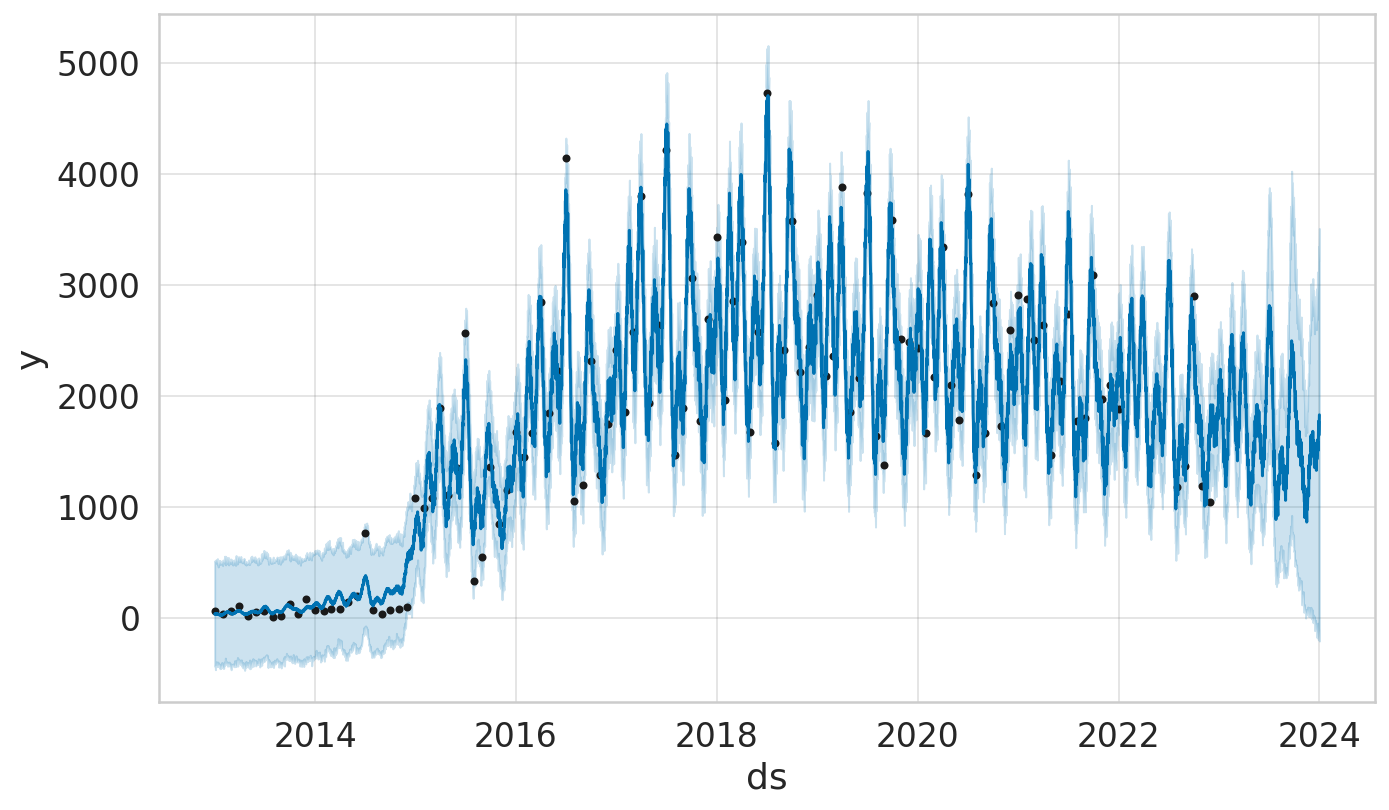

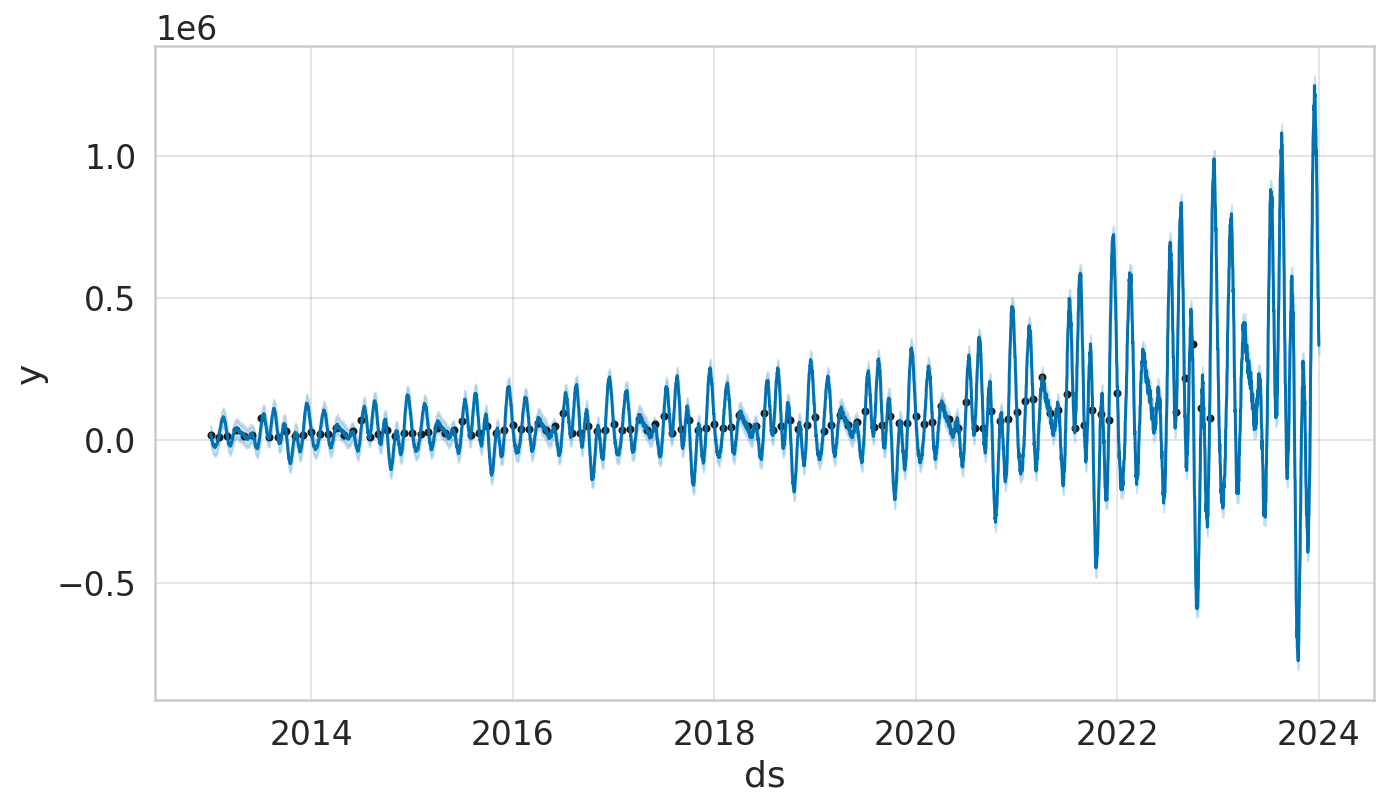

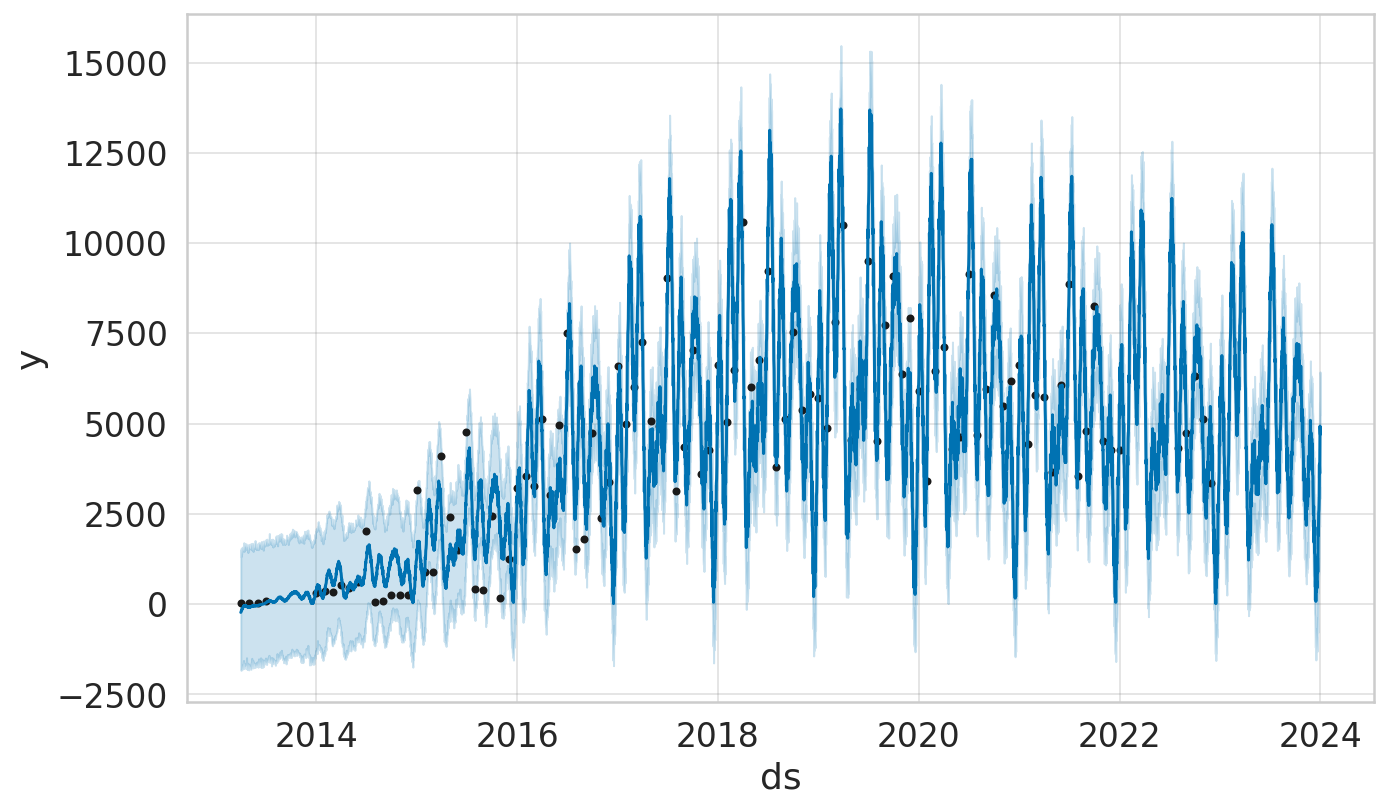

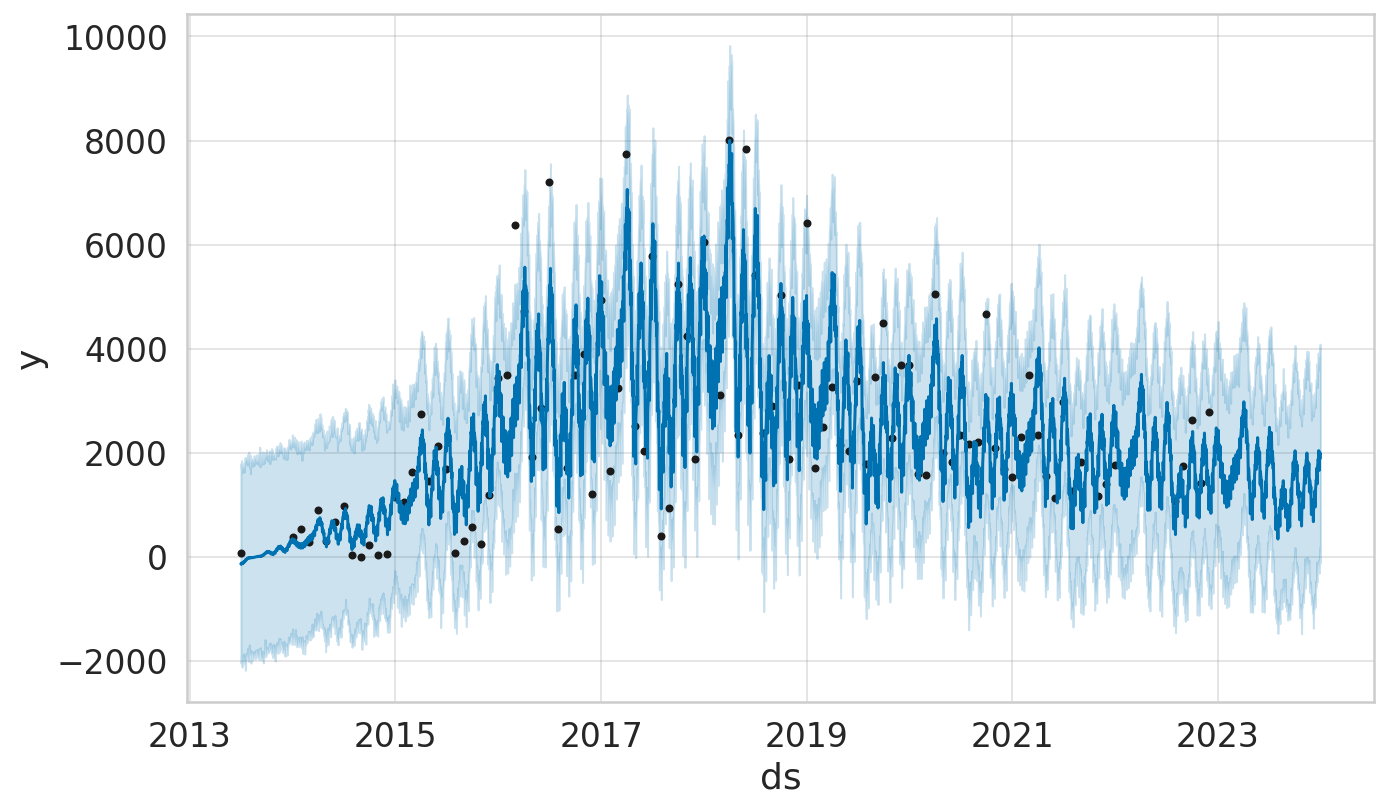

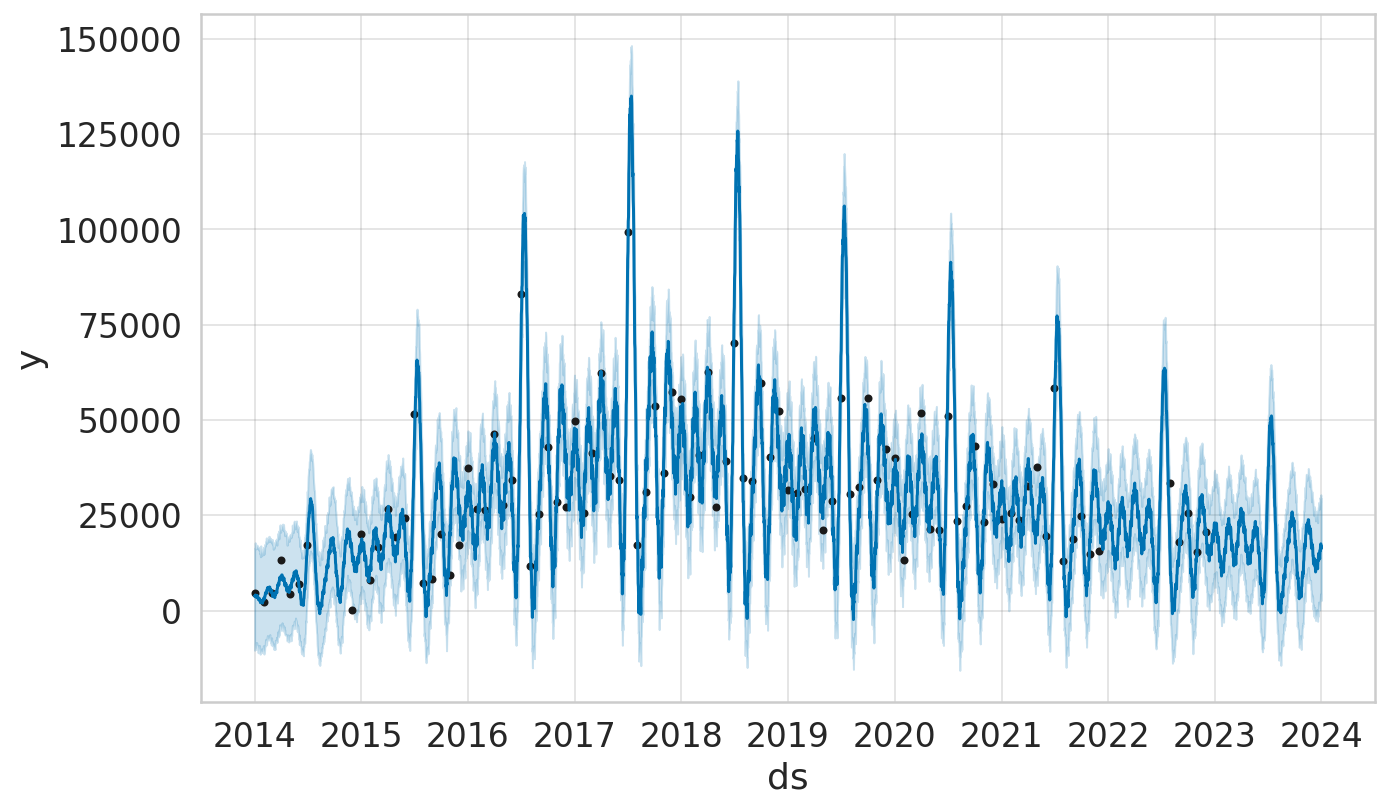

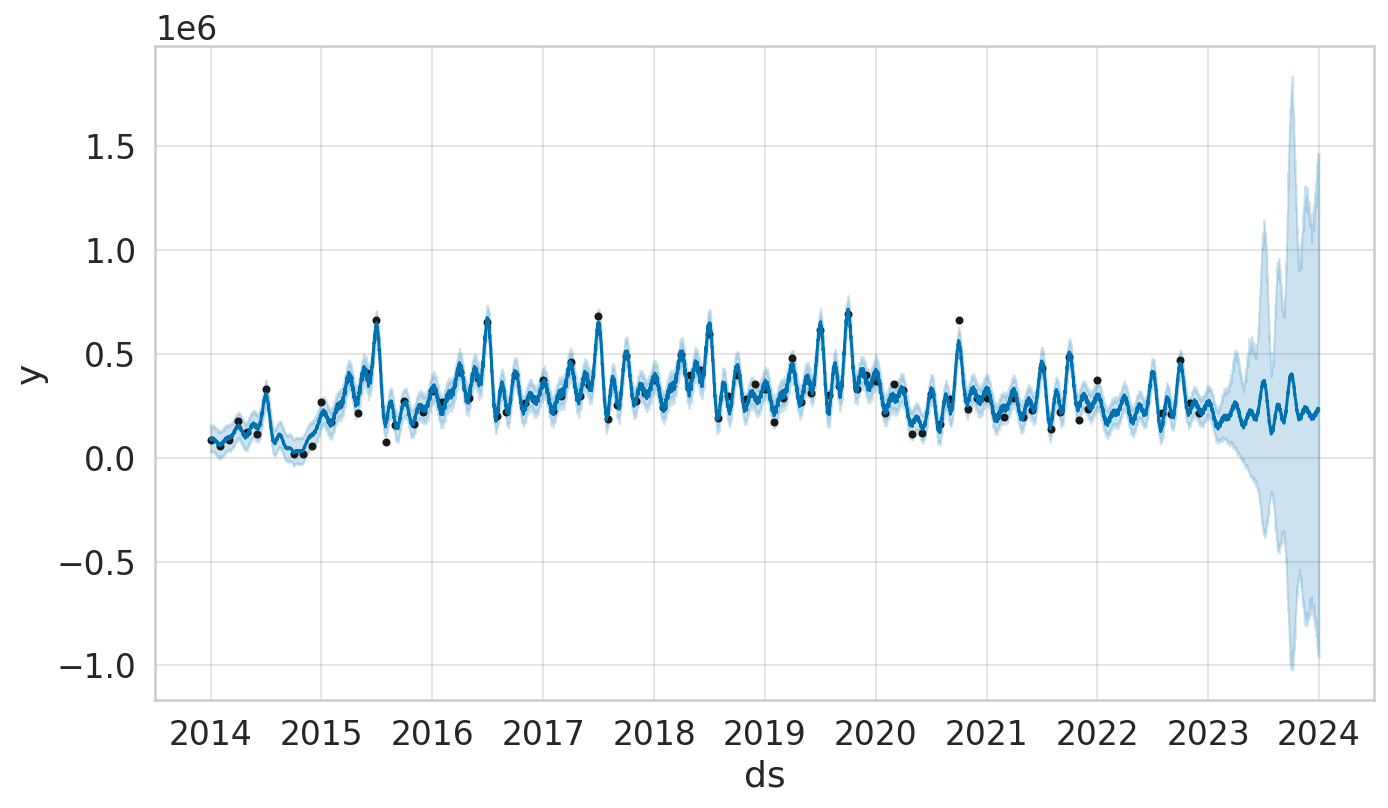

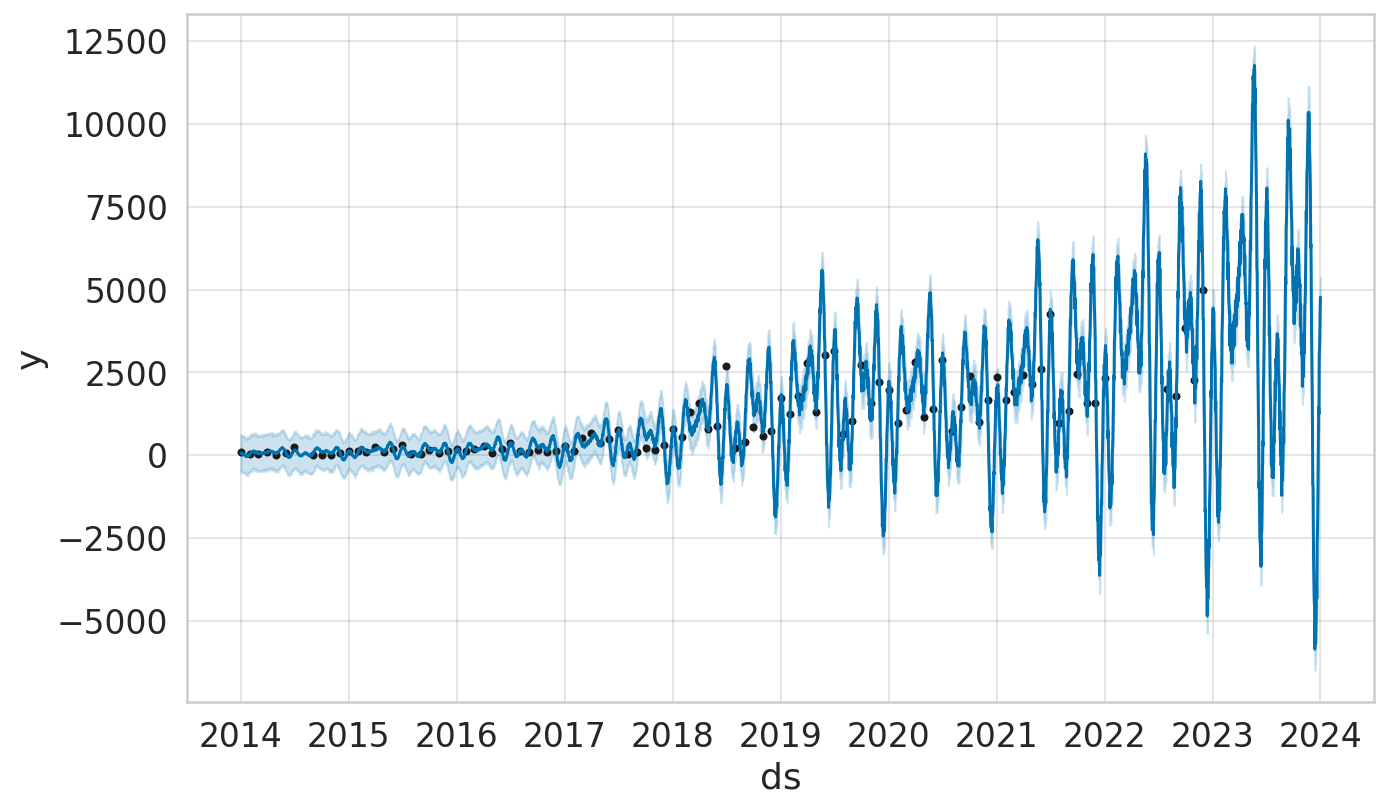

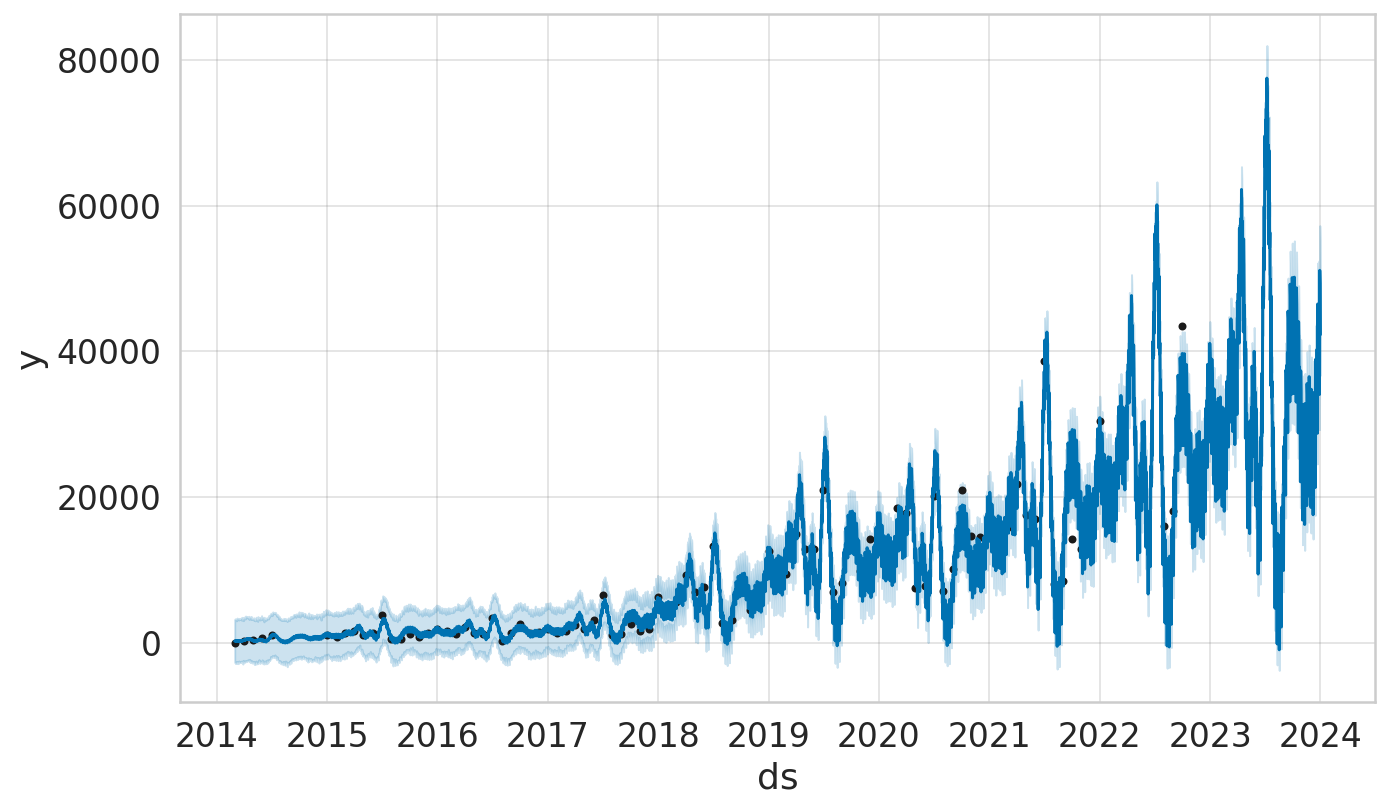

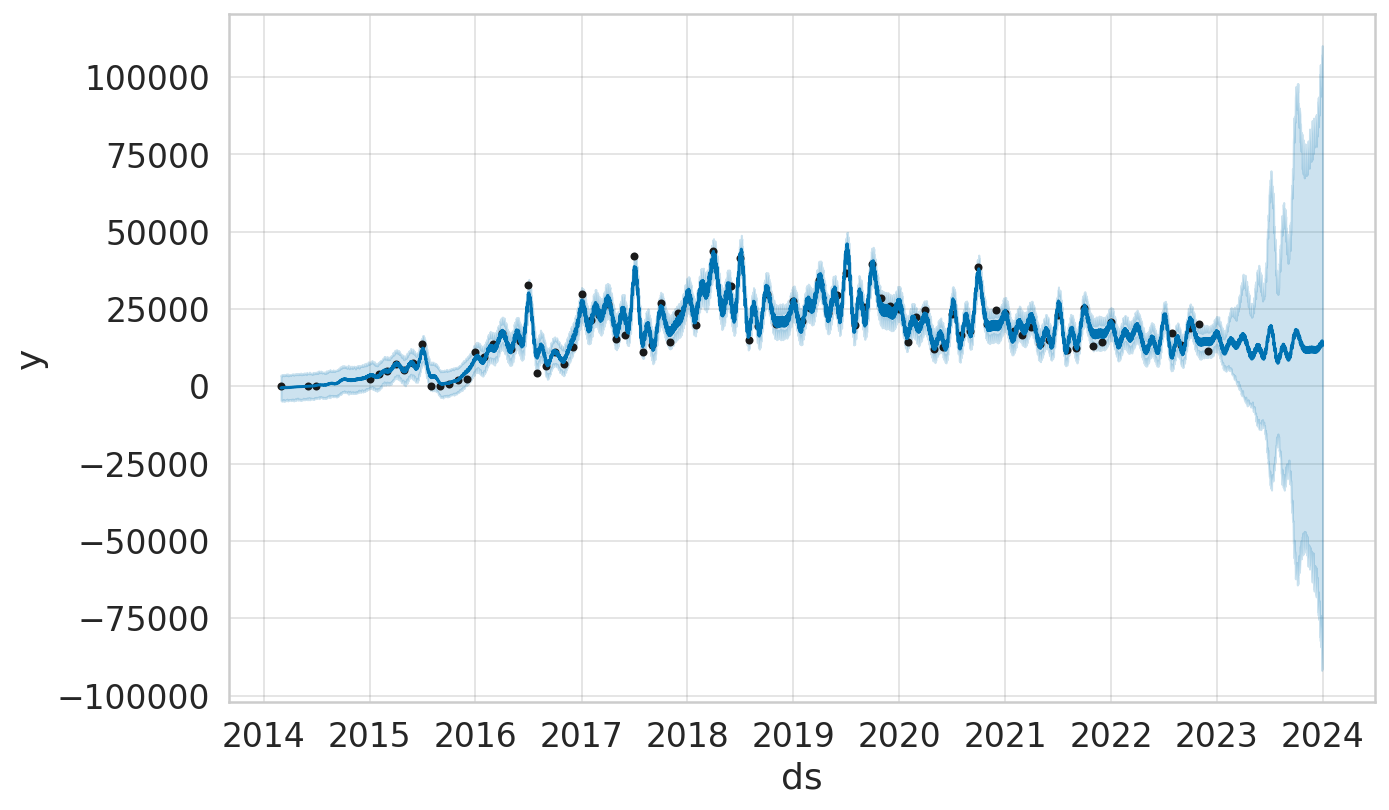

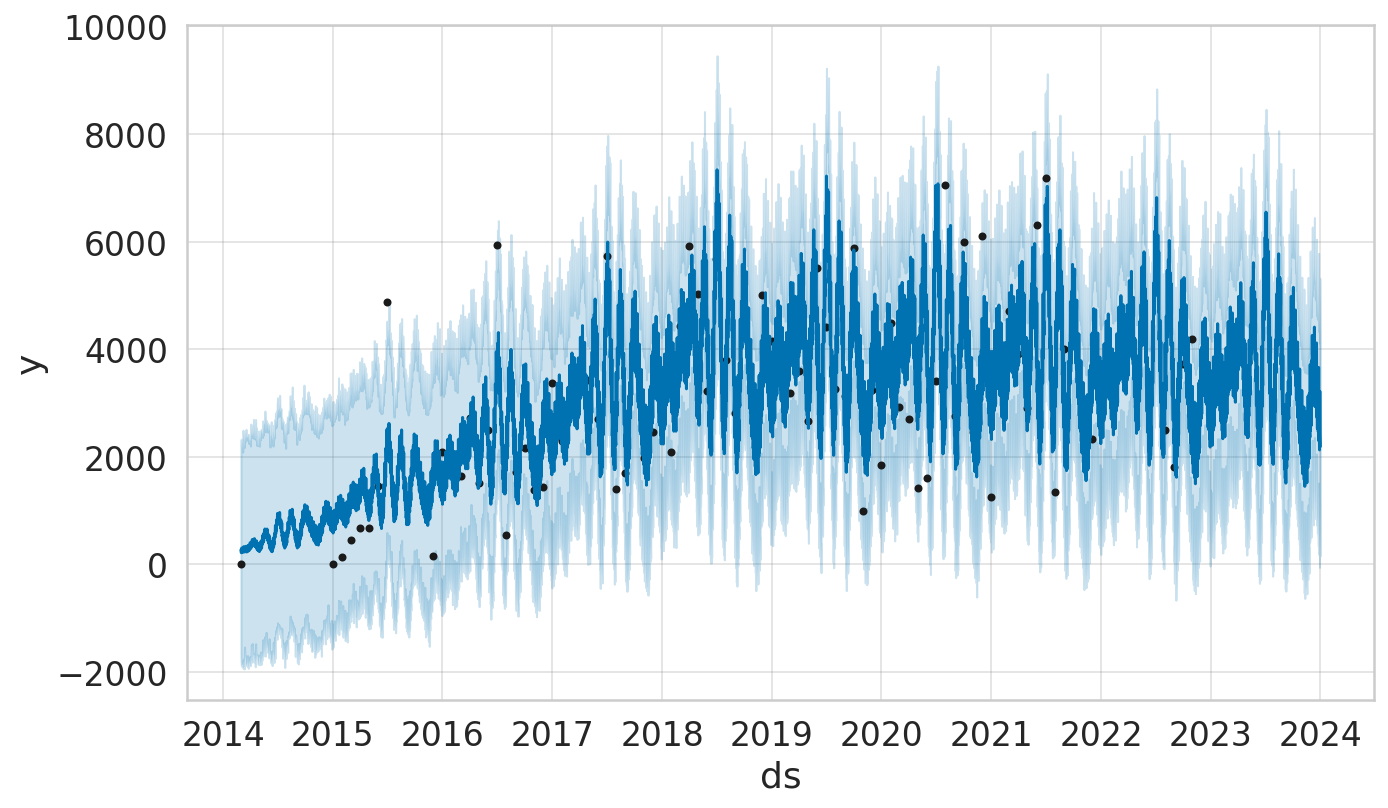

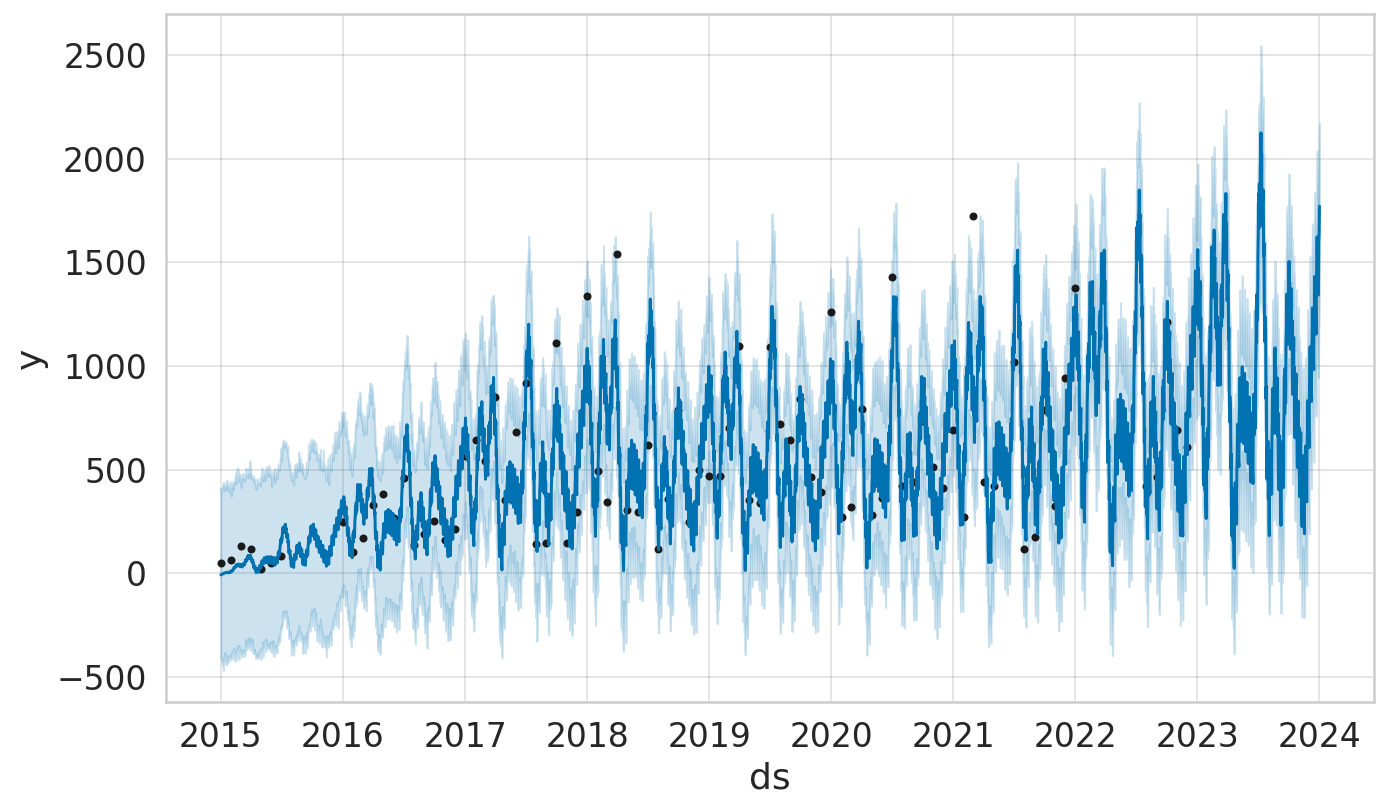

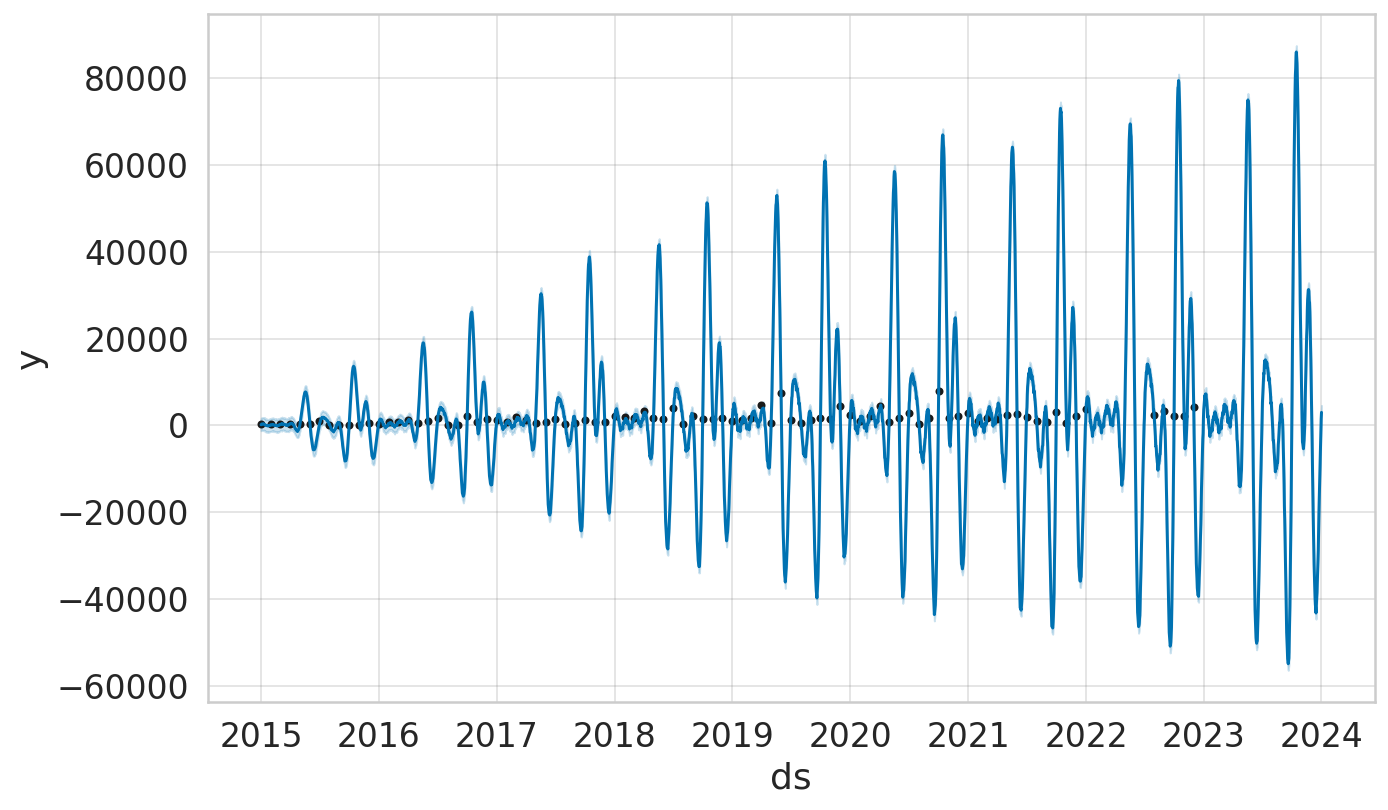

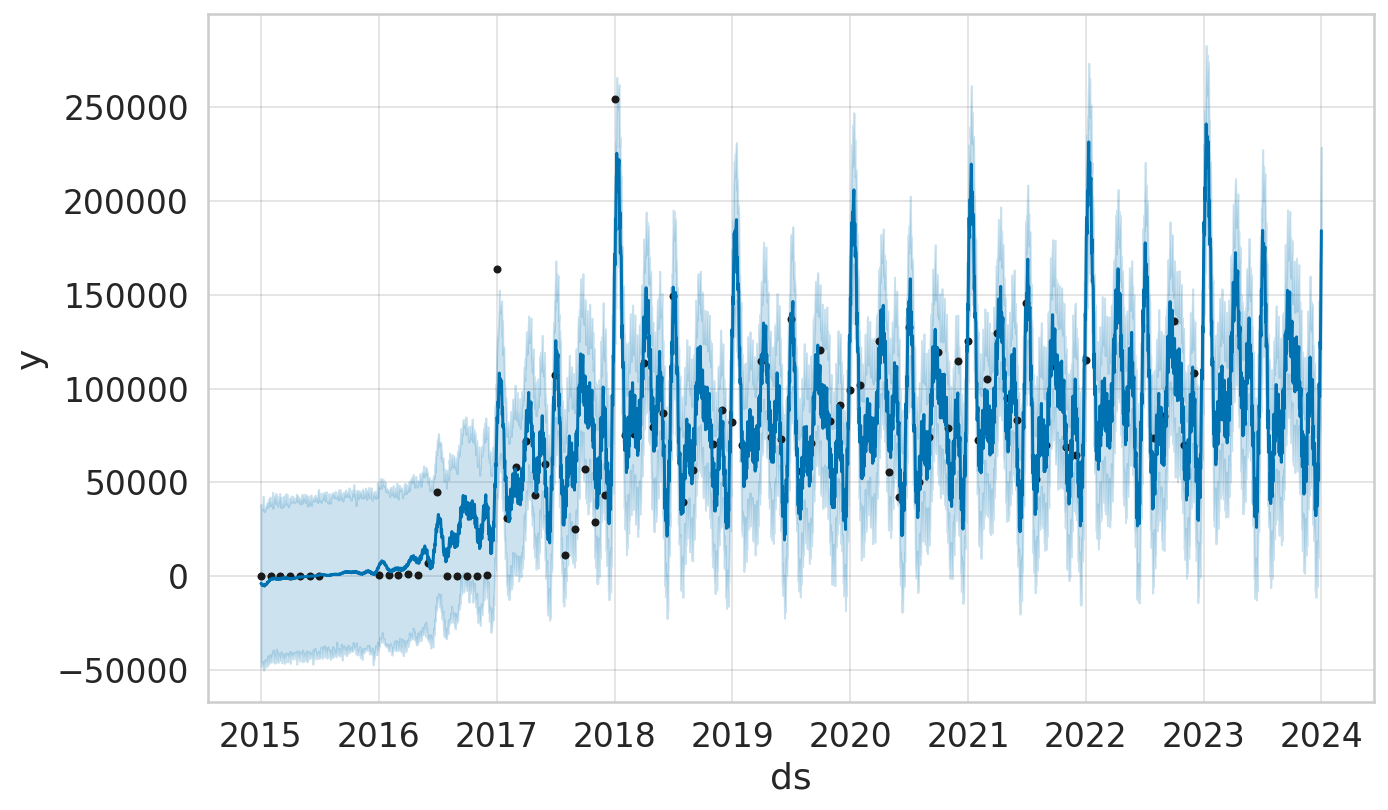

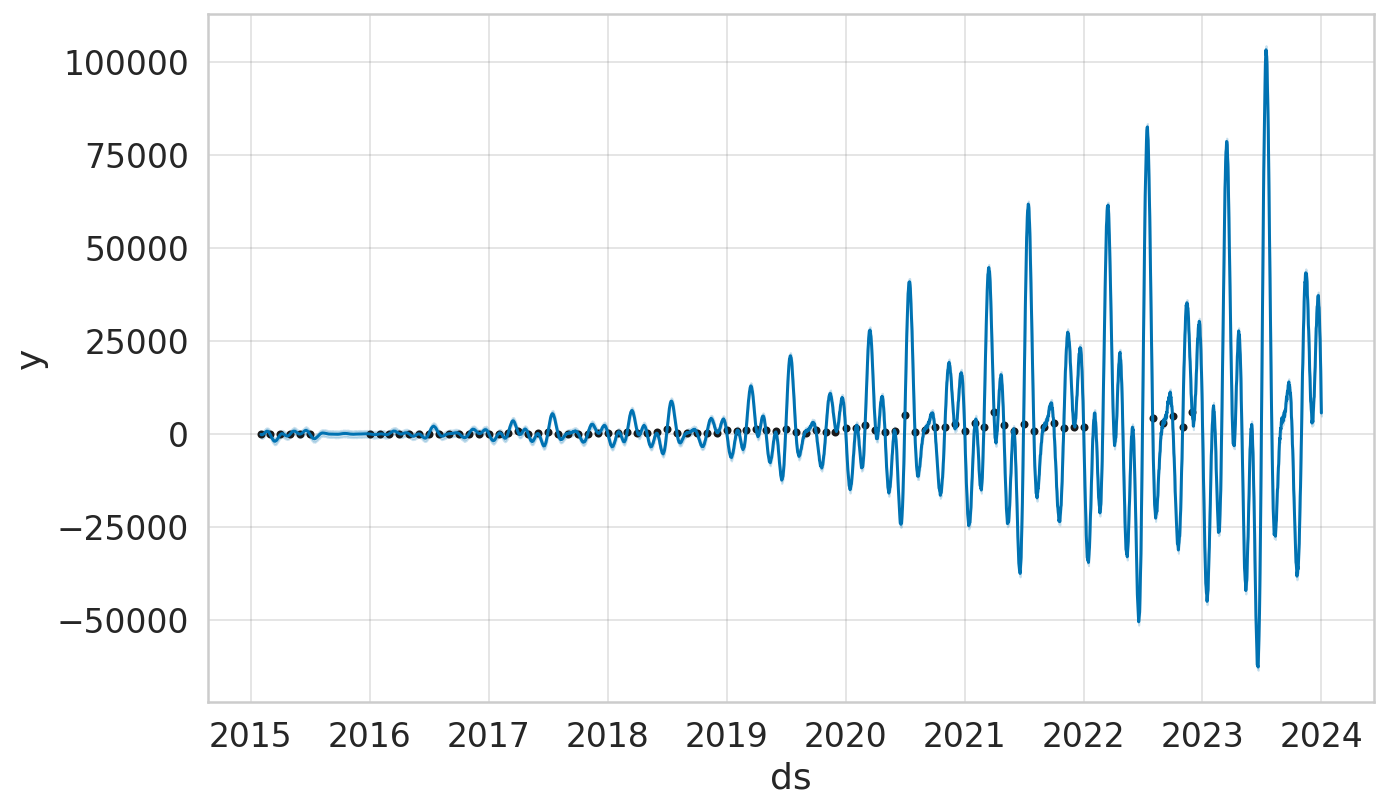

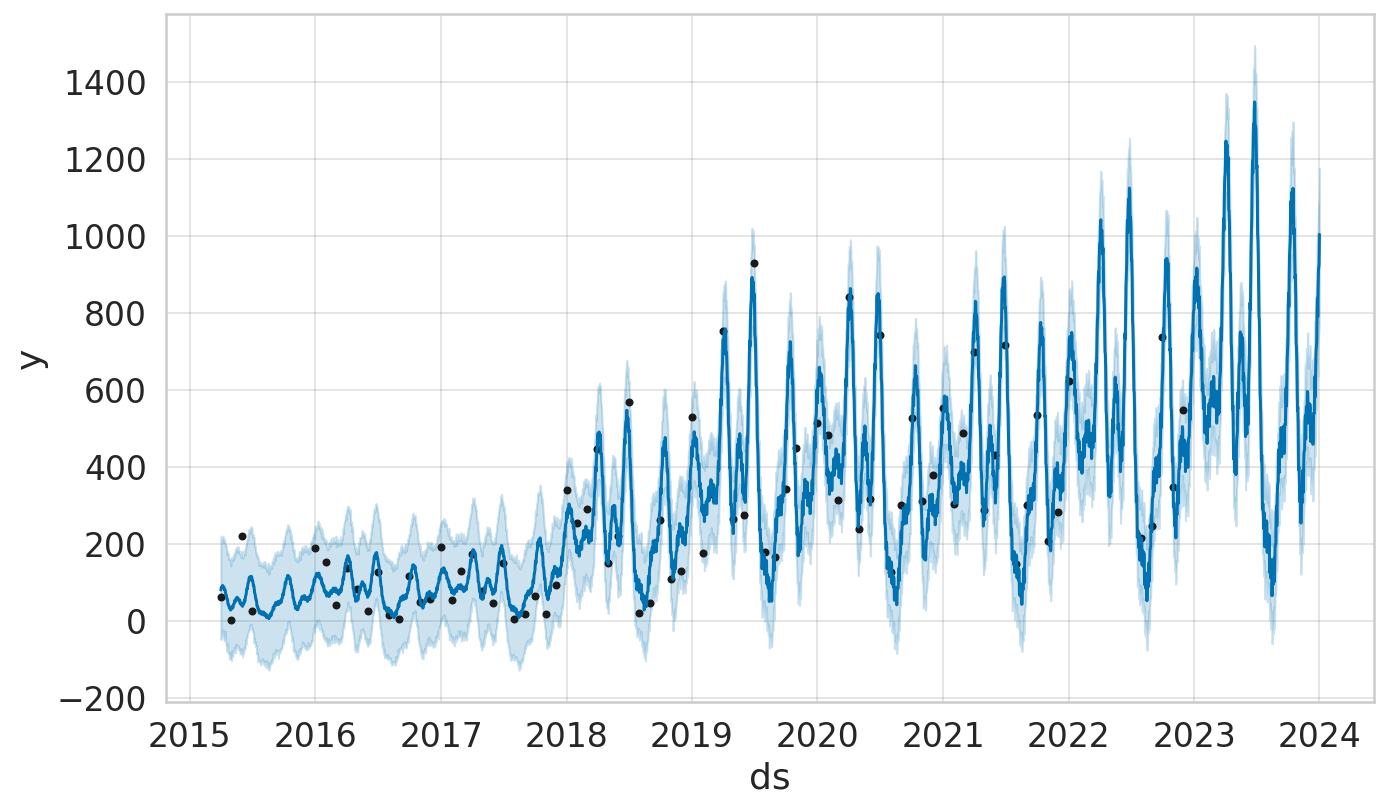

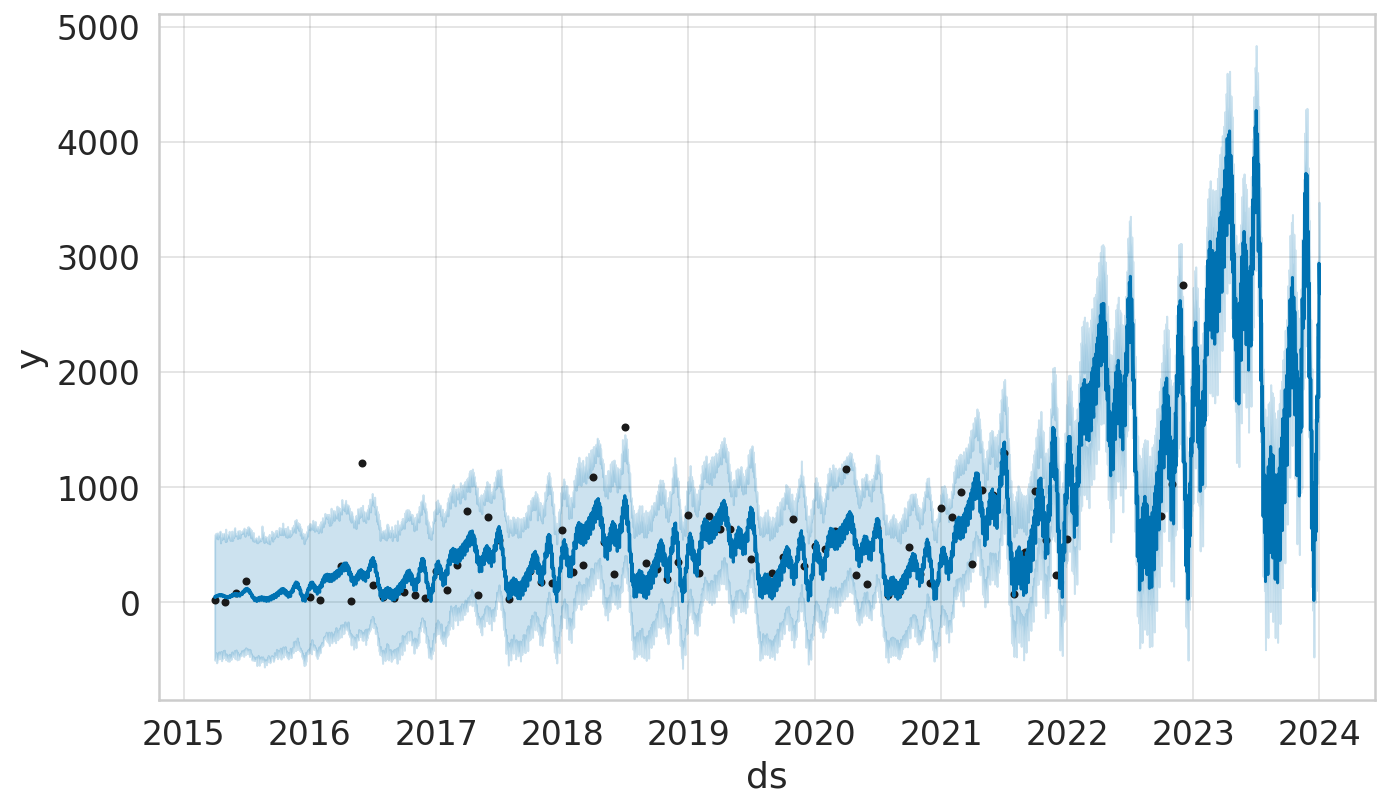

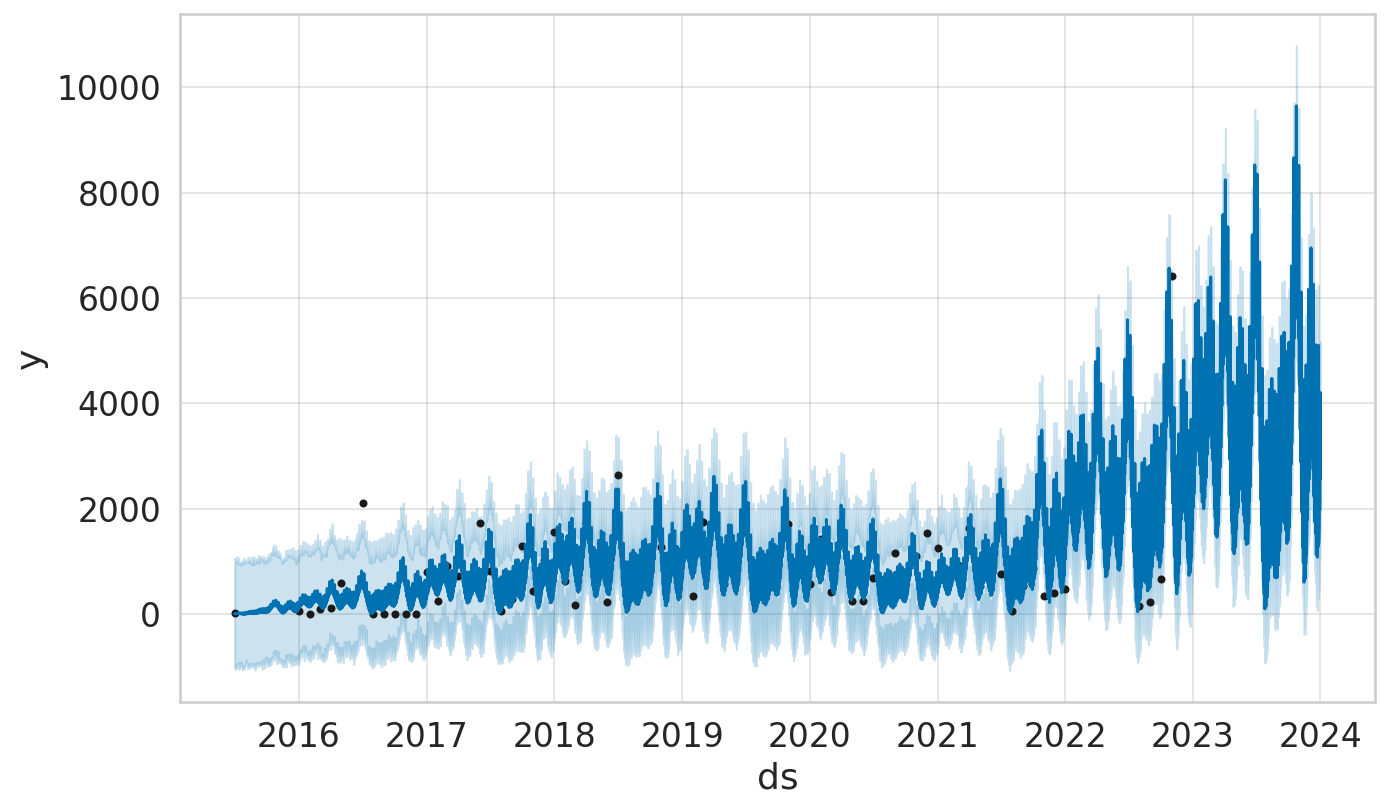

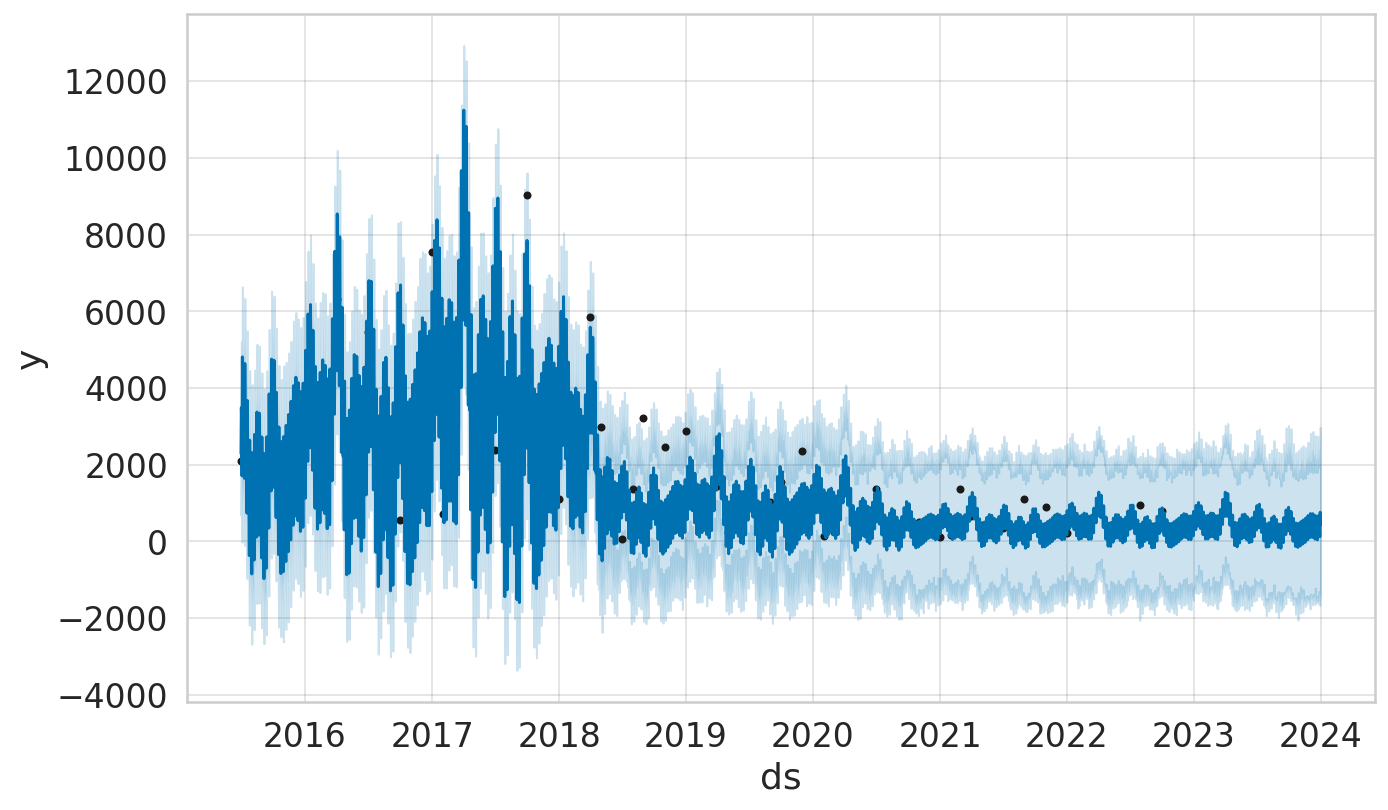

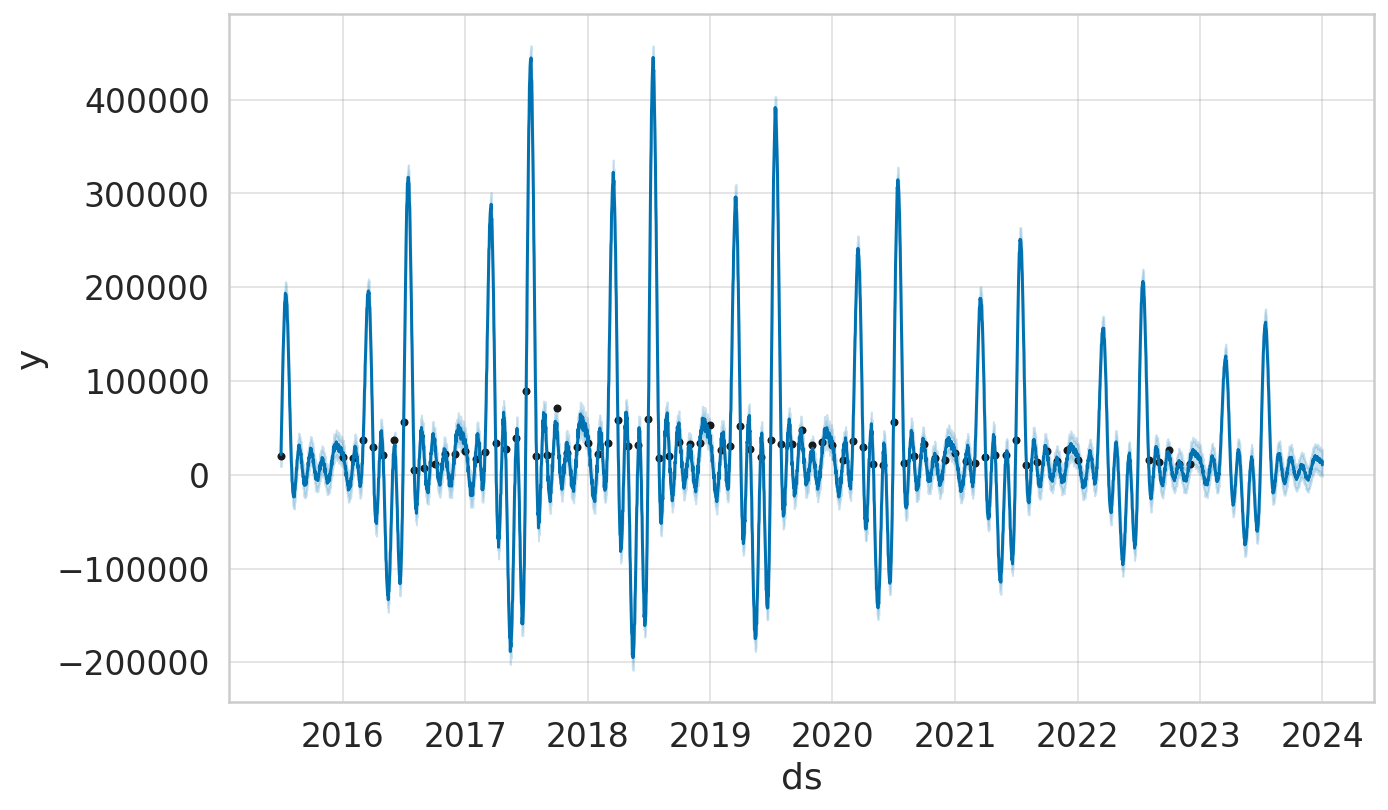

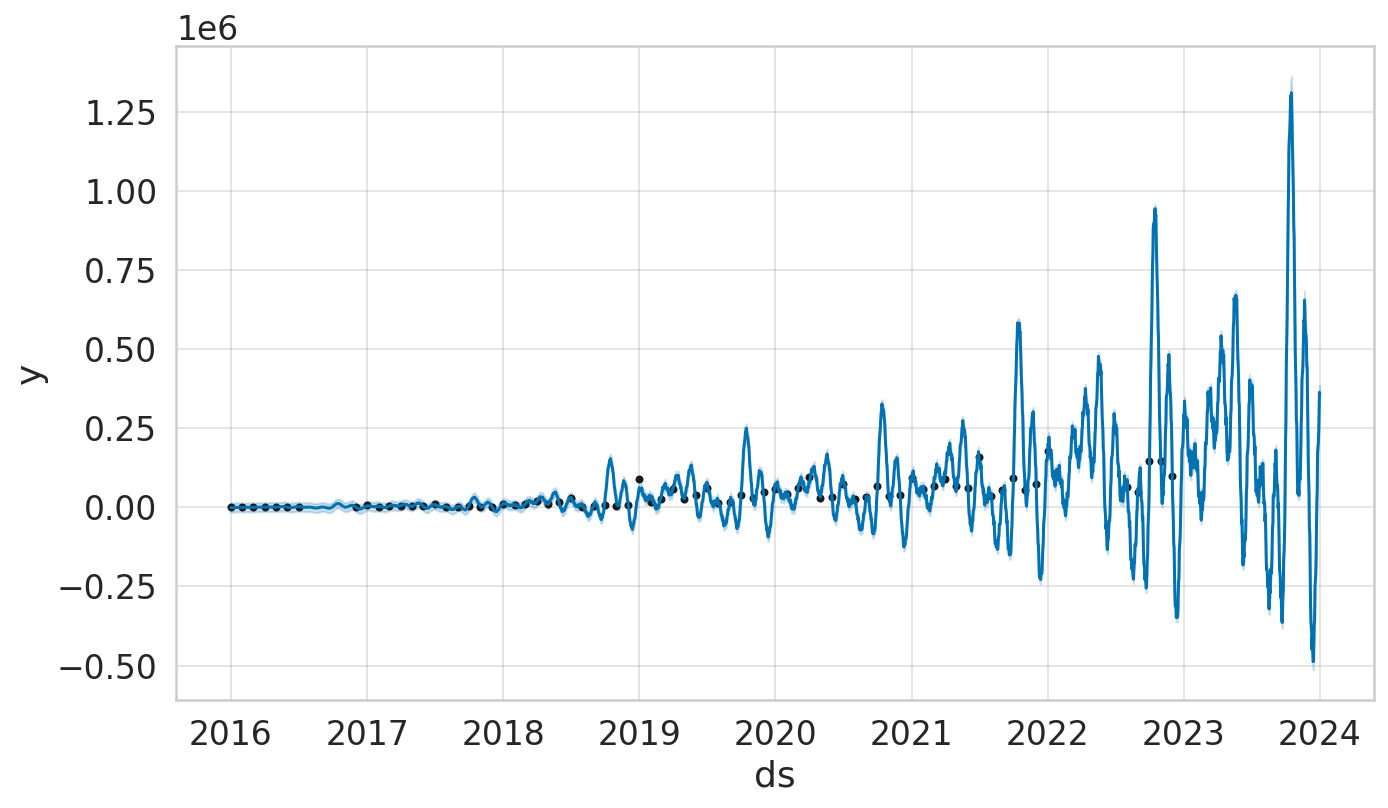

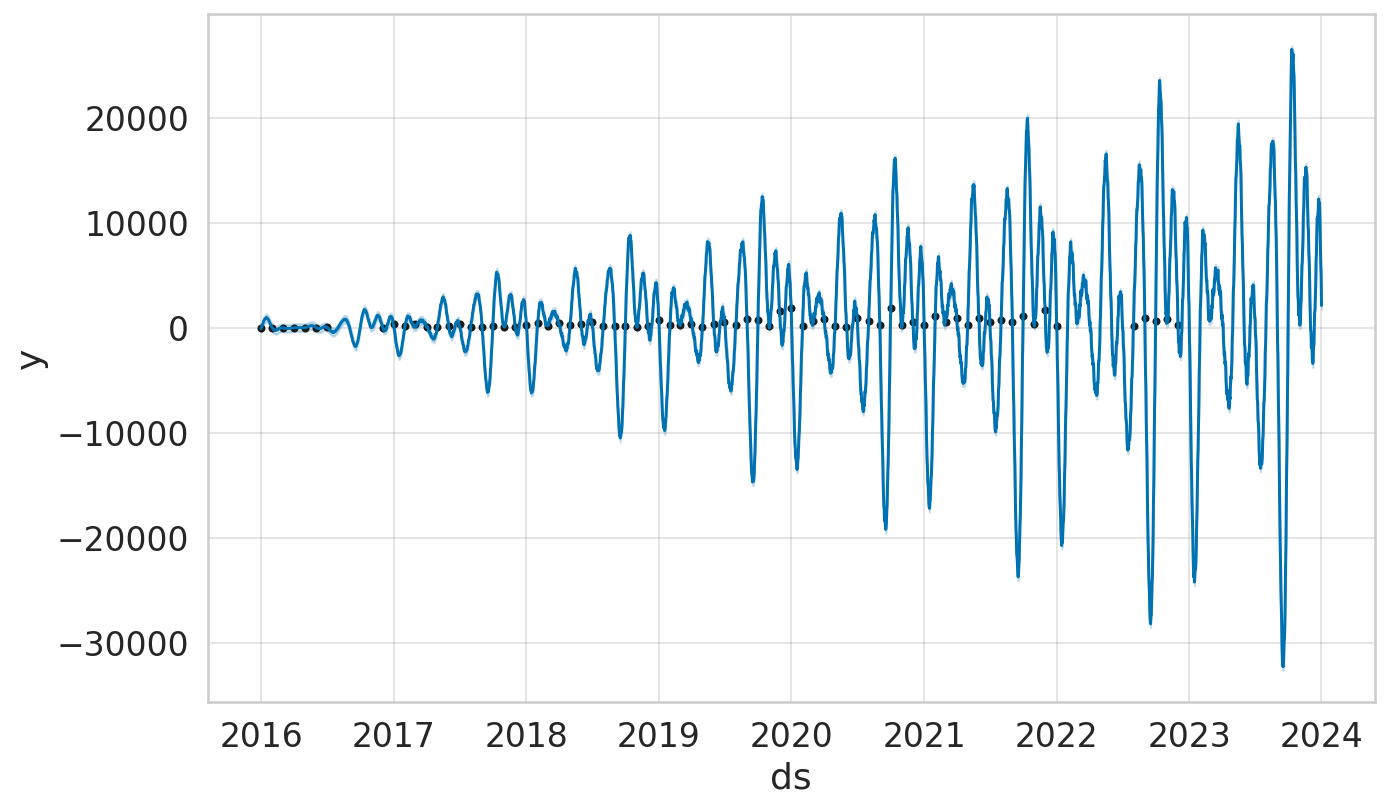

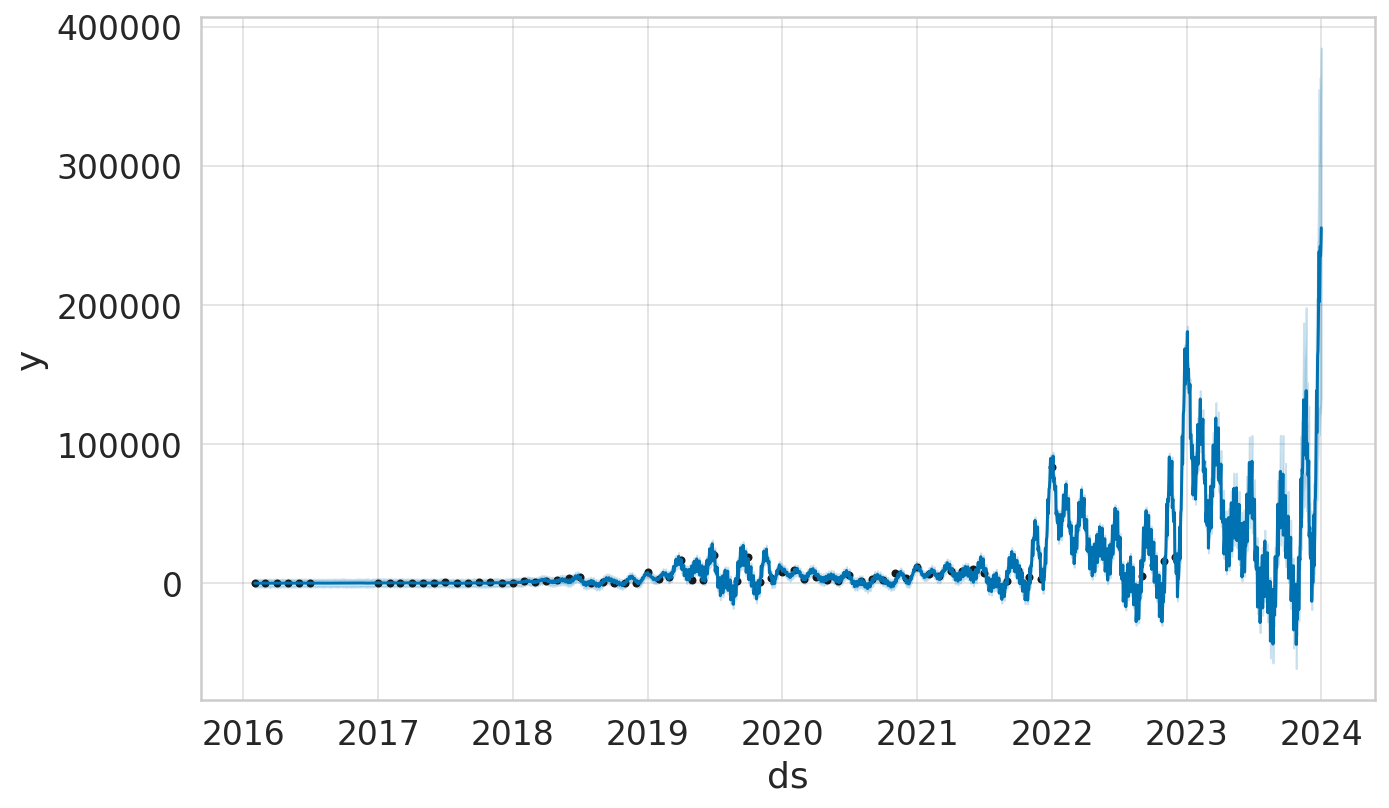

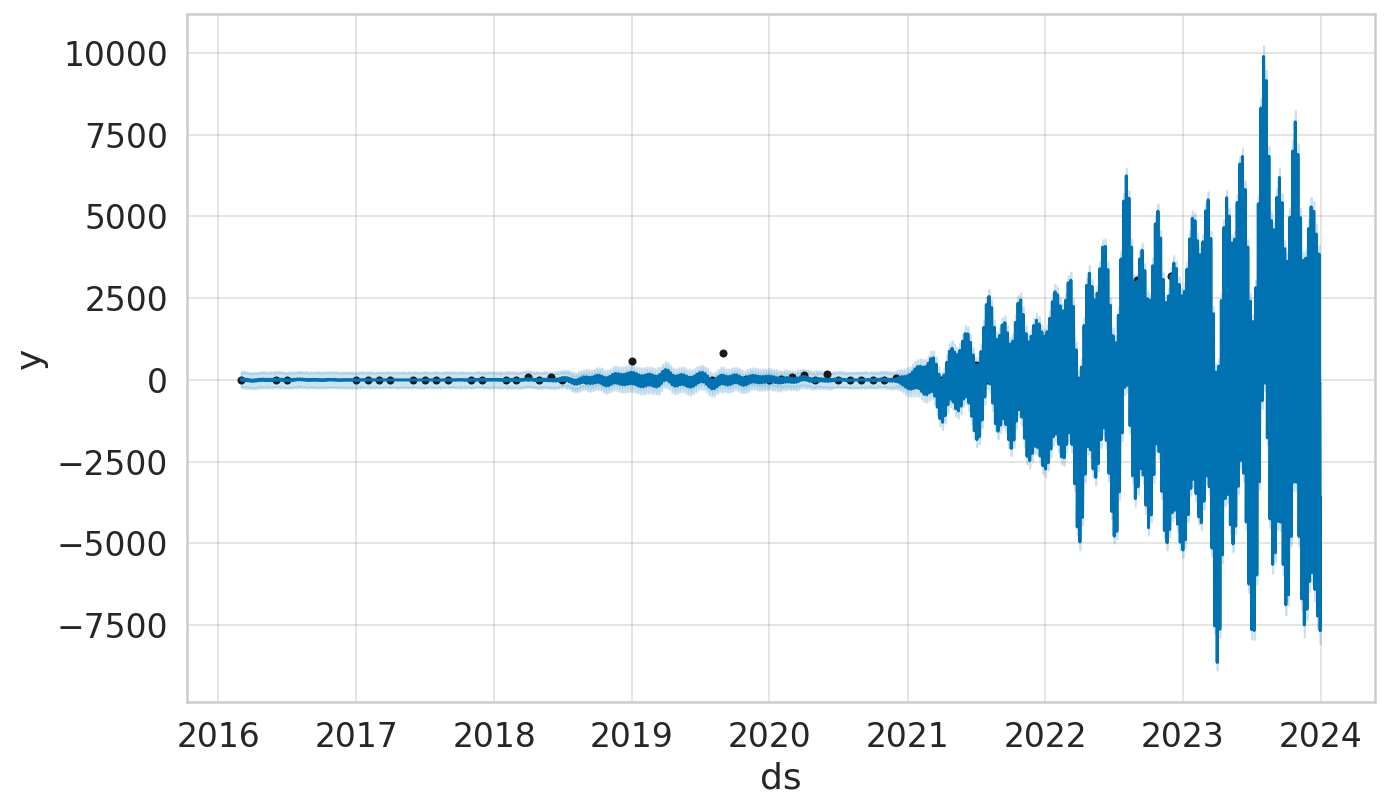

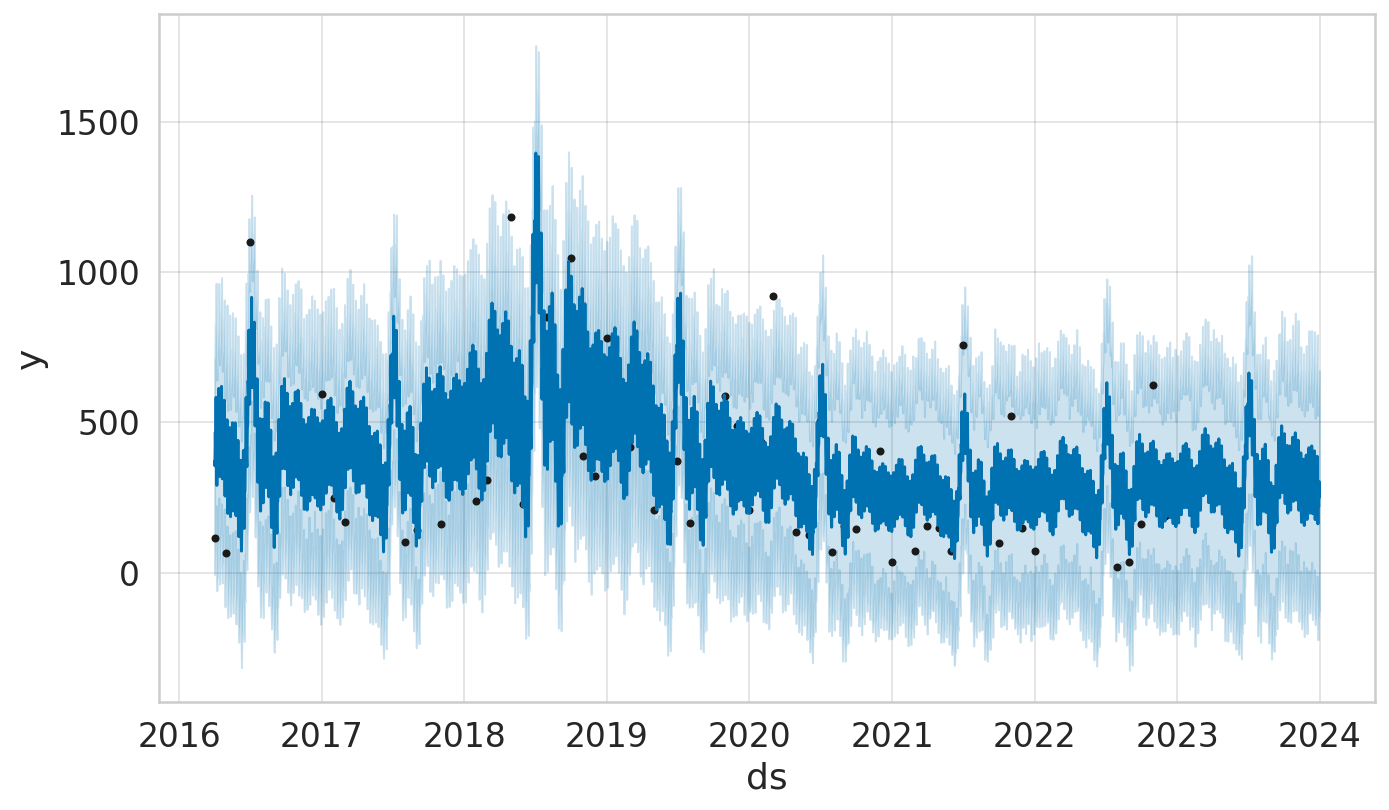

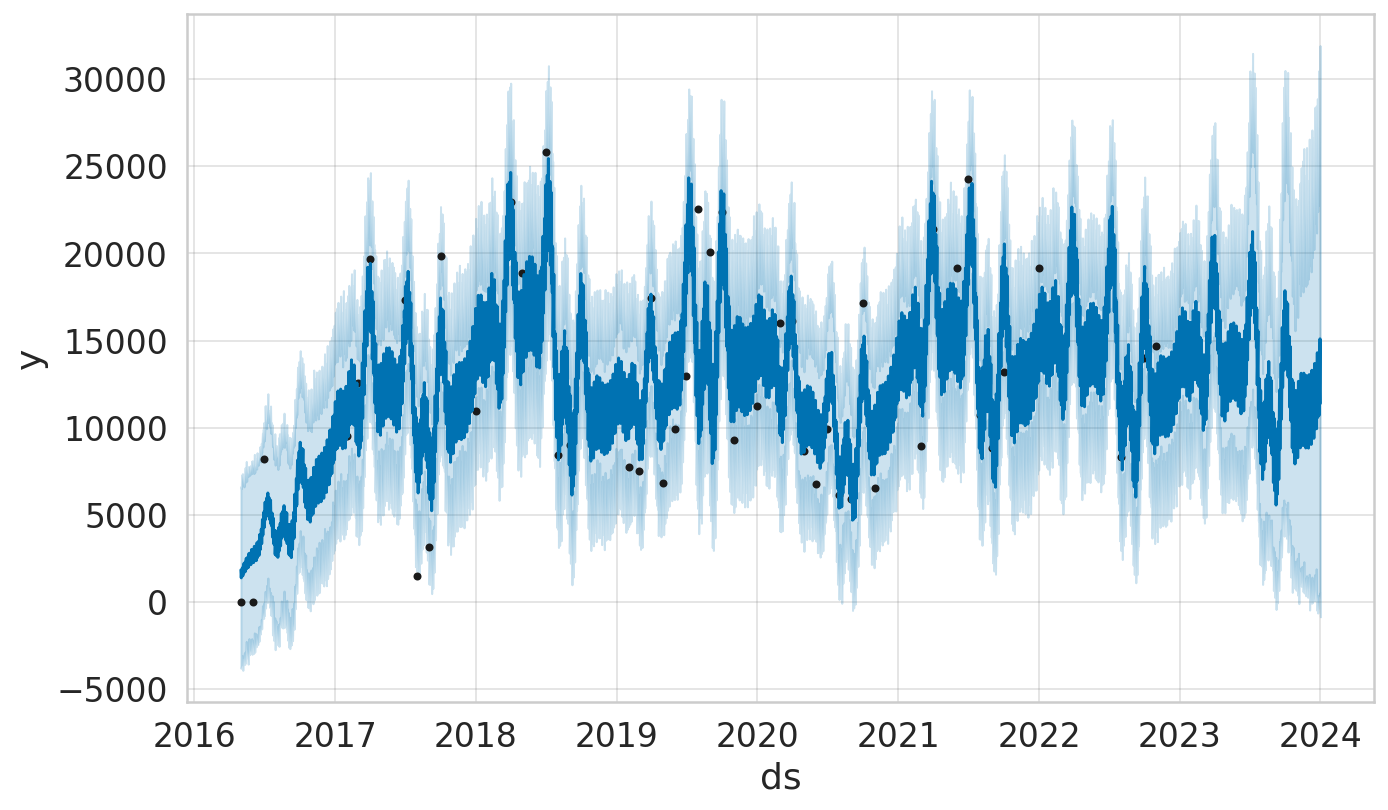

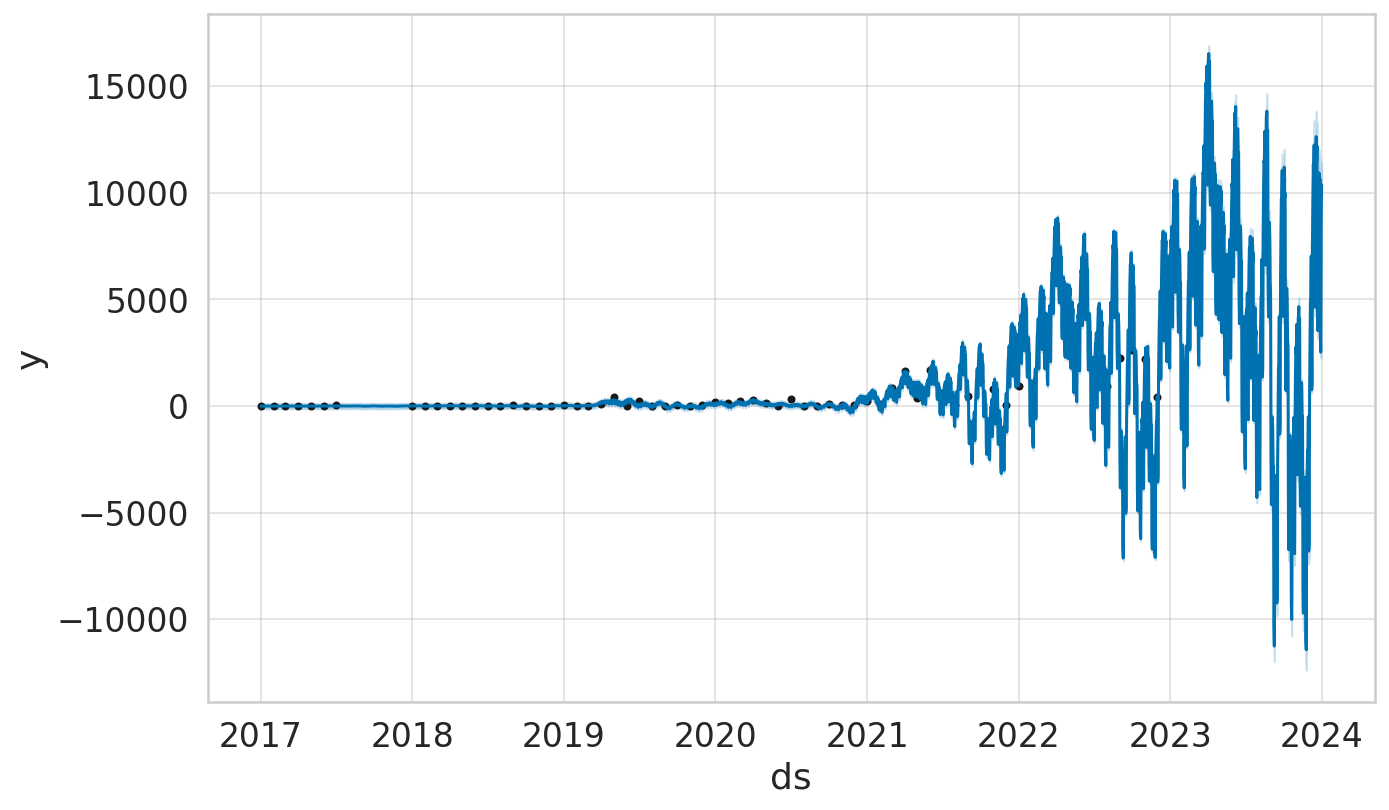

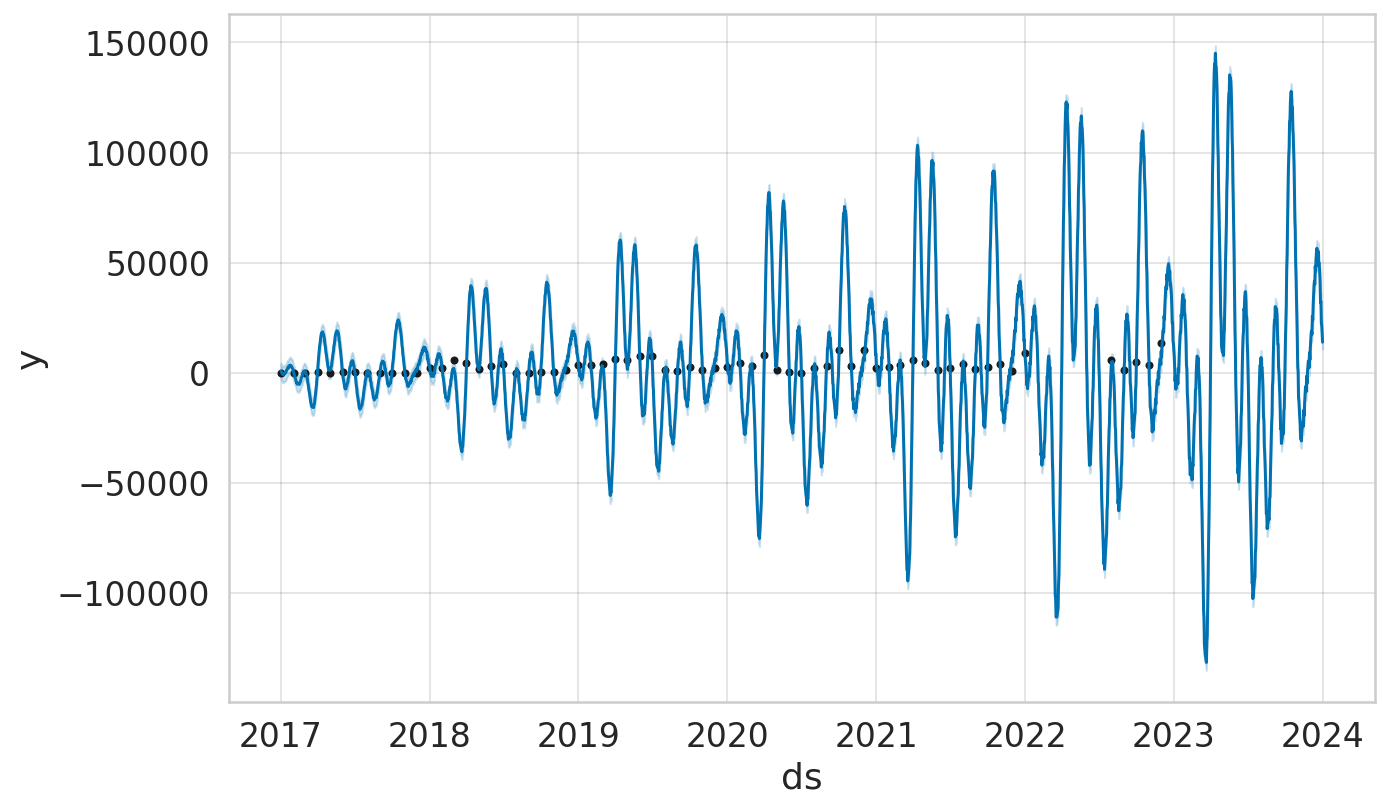

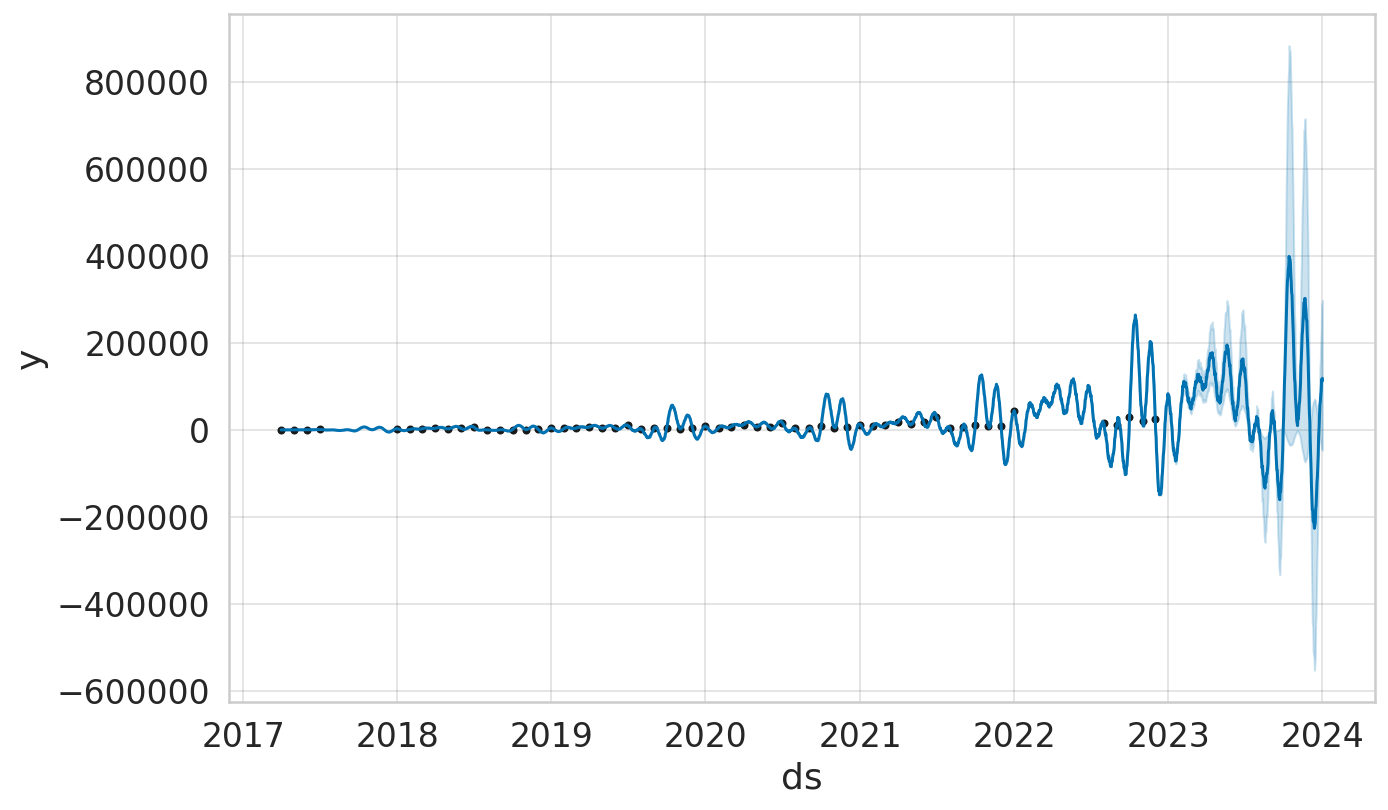

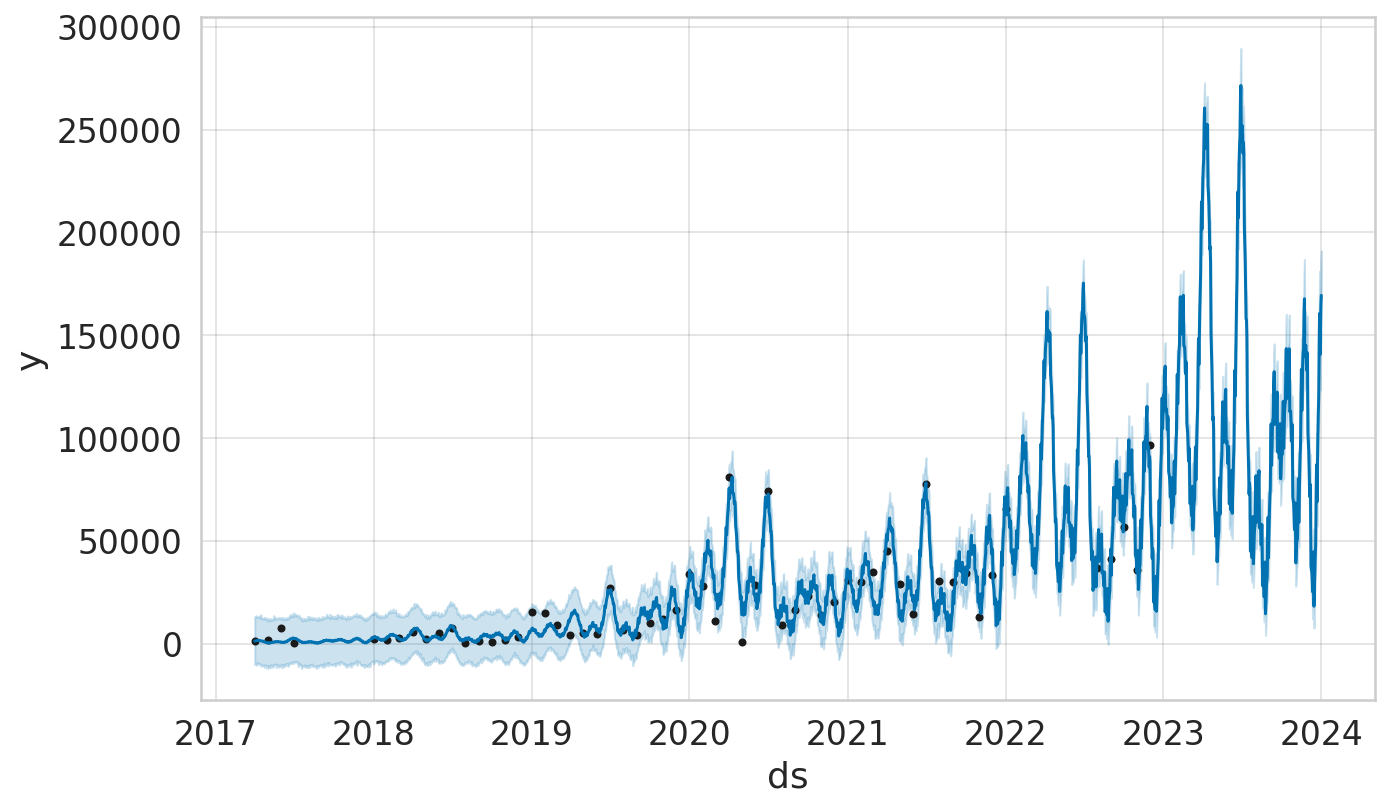

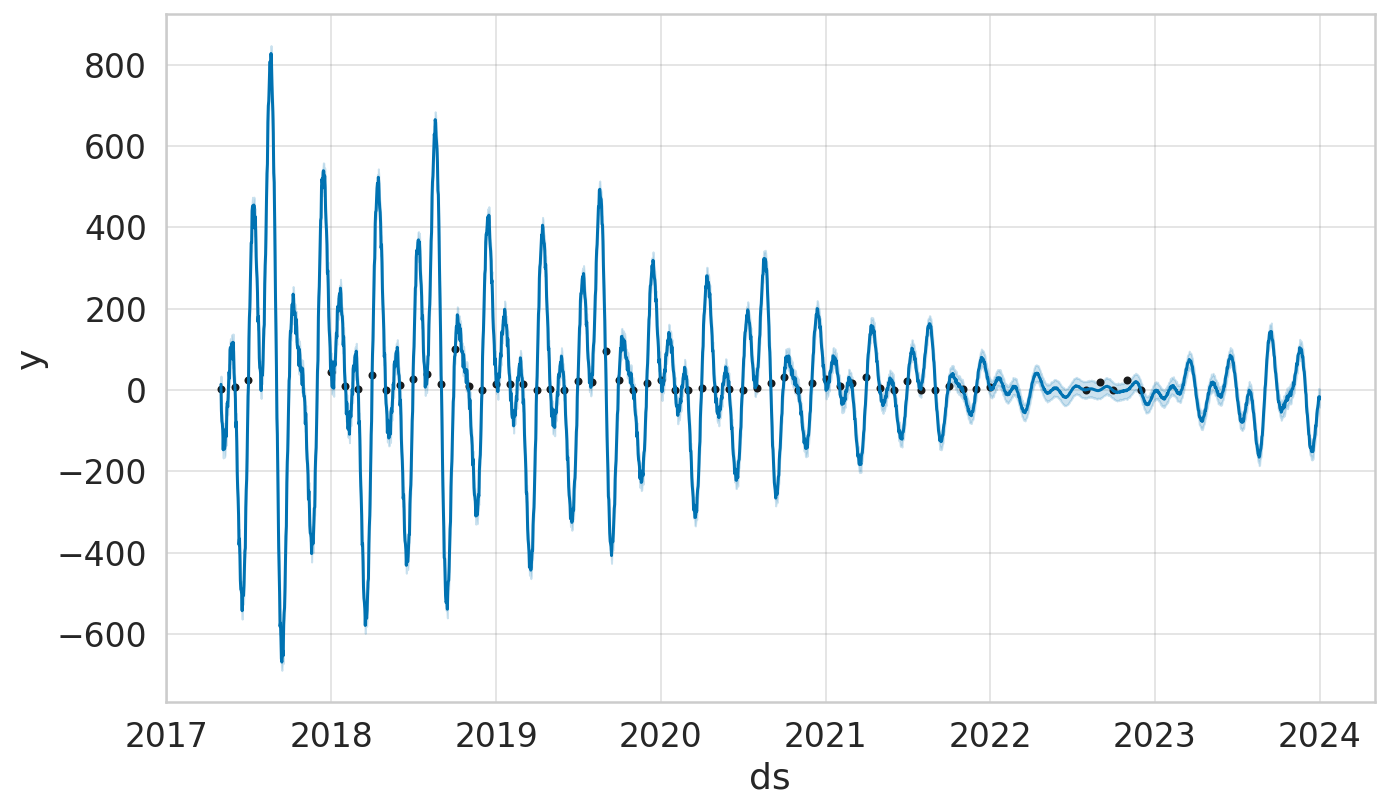

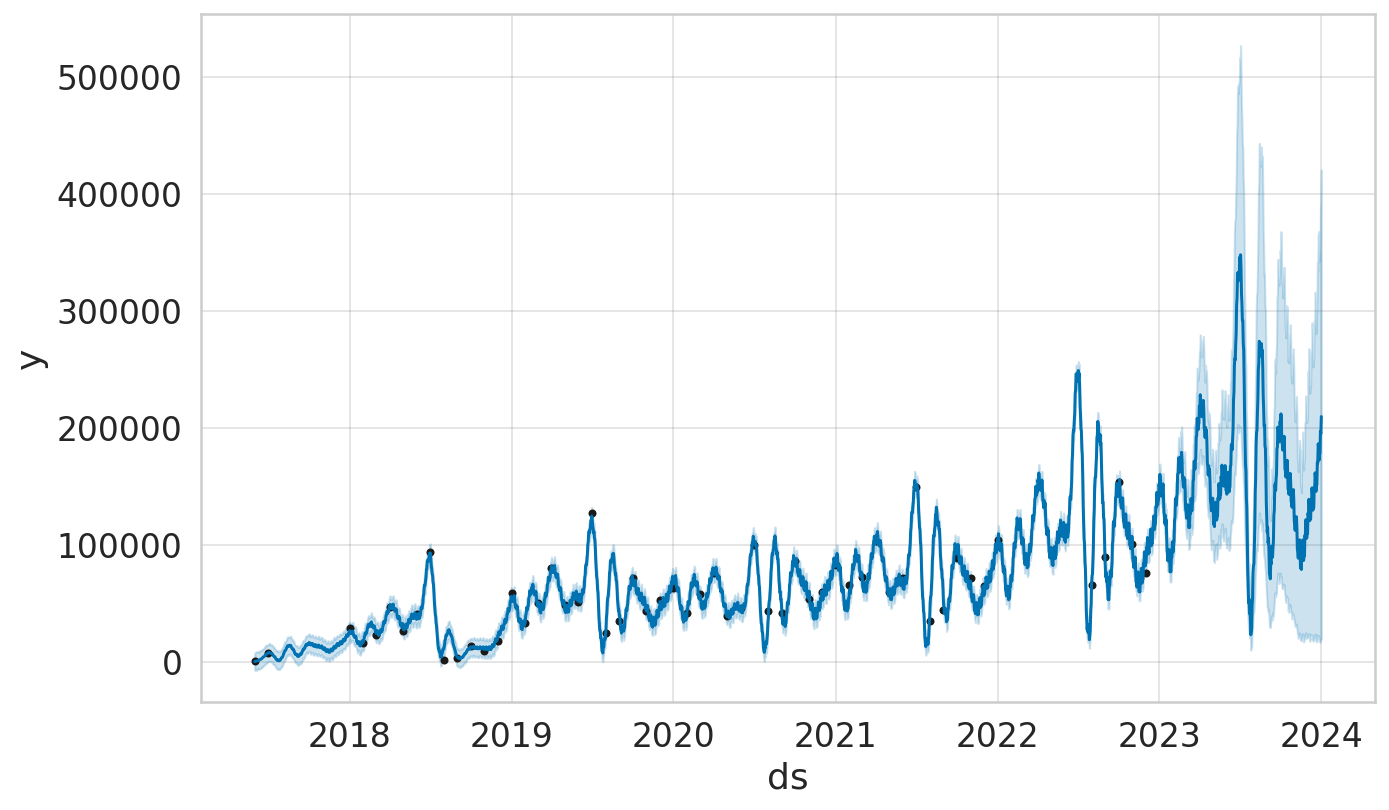

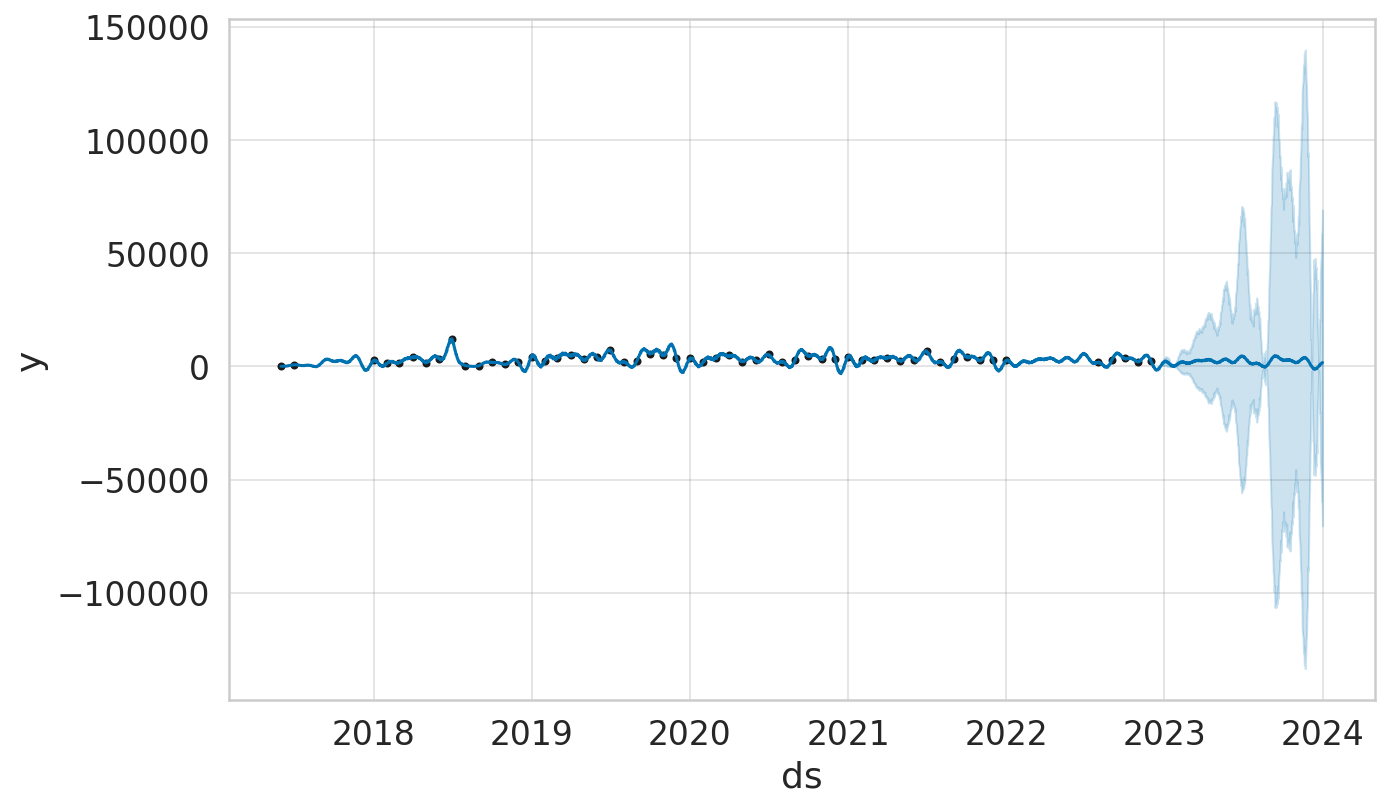

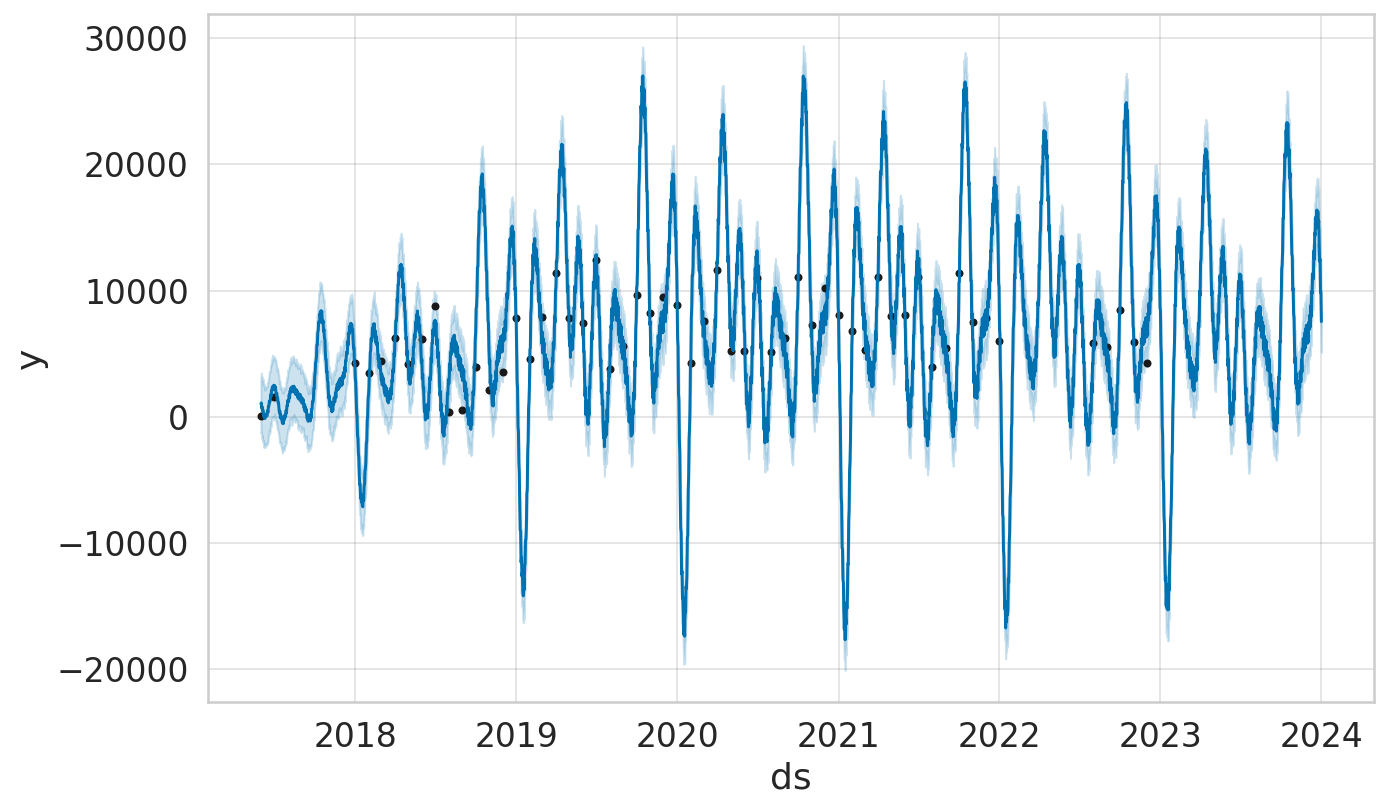

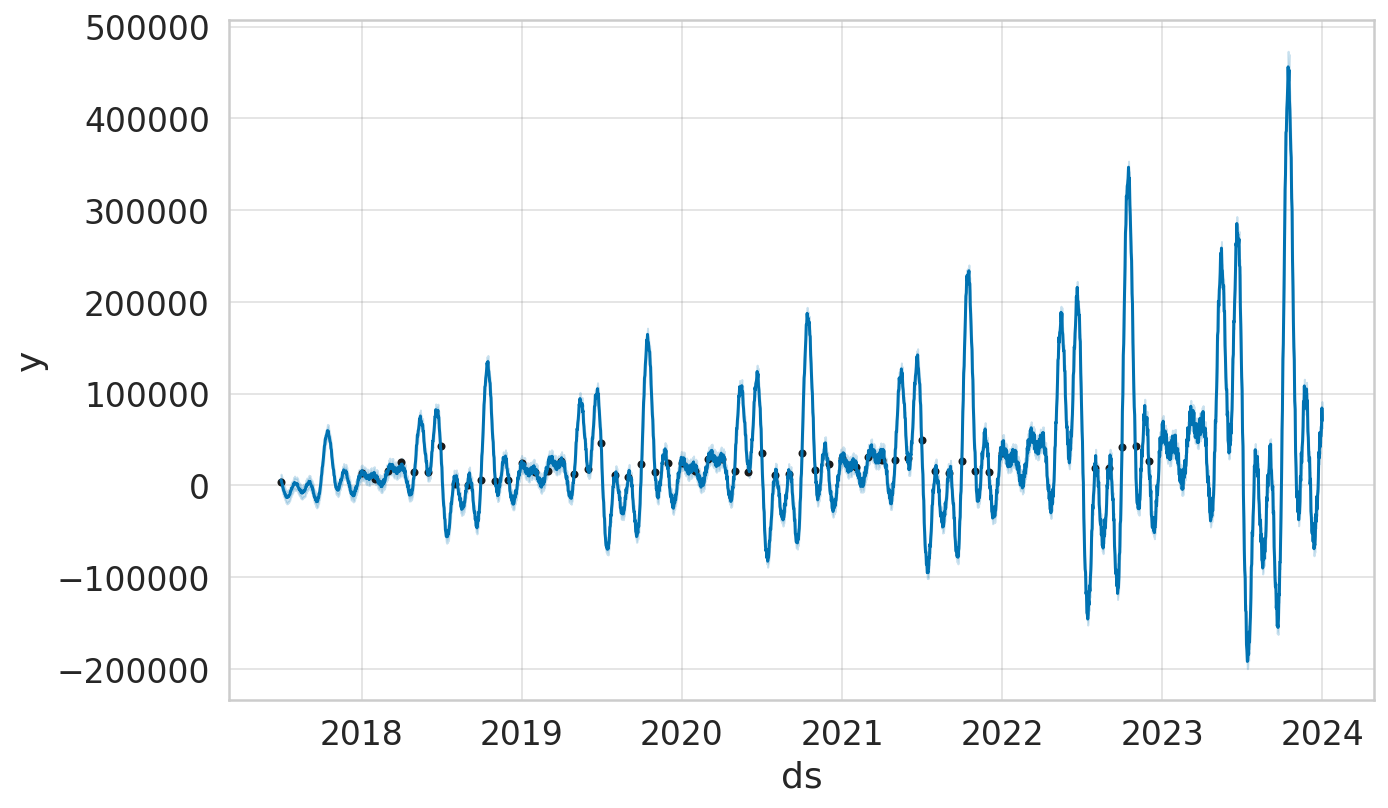

Error in callback <function flush_figures at 0x7f9a2375bd30> (for post_execute):


KeyboardInterrupt: ignored

In [41]:
# regressing by product family

num = {}
with open("numerifications.json", 'r') as f:
    num = json.load(f)

for i in range(no_fams):
    train_data, test_data = train_test_split(df.loc[df['product_family'] == i][["booking_date", "booked_qty"]], test_size=0.15, shuffle=True)
    train_data = df.loc[df['product_family'] == i][["booking_date", "booked_qty"]] # for model making
   
    train_df = train_data.copy()
    train_df.columns = ["ds", "y"]
    train_df = train_df.sort_values(by='ds')
    train_df = train_df.reset_index()
    train_df.drop("index", inplace = True, axis = 1)

    # test_df = test_data.copy()
    # test_df.columns = ["ds", "y"]
    # test_df = train_df.sort_values(by='ds')
    # test_df = train_df.reset_index()
    # test_df.drop("index", inplace = True, axis = 1)

    mae_scores = []
    rmse_scores = []
    
    print("before mean:", train_df.shape)
    print(train_df.head())
    
    train_df = train_df.groupby("ds")["y"].sum()
    train_df = train_df.reset_index()
    train_df.columns = ["ds", 'y']

    # test_df = test_df.groupby("ds")["y"].sum()
    # test_df = test_df.reset_index()
    # test_df.columns = ["ds", 'y']

    print("after mean:", train_df.shape)
    print(train_df.head())

    model = Prophet(changepoint_prior_scale= 0.5,
                    seasonality_prior_scale=1,
                    n_changepoints = 200, 
                    seasonality_mode = 'multiplicative', 
                    weekly_seasonality=True, 
                    daily_seasonality = True, 
                    yearly_seasonality = True, 
                    interval_width=0.95) 
    model.fit(train_df)

    fam_name = num["Product Family"][str(i)]
    print("Family Name:", fam_name)

    # extrapolating output
    start = train_df["ds"].iloc[0]
    future = pd.DataFrame(pd.date_range(start = start, end='2024-01-01'), columns=['ds'])
    forecast = model.predict(future)

    # calculate error
    # mae = mean_absolute_error(test_df['y'], forecast['yhat'])
    # rmse = np.sqrt(mean_squared_error(test_df['y'], forecast['yhat']))
    # print(f"For Product Family {fam_name}, MAE: {mae}, RMSE: {rmse}")
    
    # dump json model
    with open(f"prophet_models/{fam_name}.json", 'w') as f:
        json.dump(model_to_json(model), f, indent = 4)

    model.plot(forecast)
    plt.savefig(f"prophet_results/{str(fam_name)}.png")




In [42]:
!zip -r prophet_results.zip prophet_results

  adding: prophet_results/ (stored 0%)
  adding: prophet_results/CTSPS.png (deflated 6%)
  adding: prophet_results/CAT8300.png (deflated 4%)
  adding: prophet_results/8000.png (deflated 5%)
  adding: prophet_results/IE4000.png (deflated 4%)
  adding: prophet_results/C9115AX.png (deflated 3%)
  adding: prophet_results/C9120AX.png (deflated 5%)
  adding: prophet_results/A9K1000.png (deflated 2%)
  adding: prophet_results/NCS1000.png (deflated 5%)
  adding: prophet_results/C9400.png (deflated 4%)
  adding: prophet_results/NCS5500.png (deflated 3%)
  adding: prophet_results/PHONVID.png (deflated 3%)
  adding: prophet_results/HXCPU.png (deflated 3%)
  adding: prophet_results/A9K9000.png (deflated 2%)
  adding: prophet_results/NCS540.png (deflated 3%)
  adding: prophet_results/NCS4200.png (deflated 8%)
  adding: prophet_results/CAT8200.png (deflated 3%)
  adding: prophet_results/CBR8.png (deflated 3%)
  adding: prophet_results/SFP10G.png (deflated 3%)
  adding: prophet_results/ONS.png (defla

In [43]:
!zip -r prophet_models.zip prophet_models

  adding: prophet_models/ (stored 0%)
  adding: prophet_models/C9300AG.json (deflated 83%)
  adding: prophet_models/CBR8.json (deflated 83%)
  adding: prophet_models/C1000.json (deflated 83%)
  adding: prophet_models/N9300.json (deflated 83%)
  adding: prophet_models/QSFP100.json (deflated 82%)
  adding: prophet_models/CPAK100.json (deflated 83%)
  adding: prophet_models/UCSSSD.json (deflated 82%)
  adding: prophet_models/NCS55FC.json (deflated 83%)
  adding: prophet_models/UCSX.json (deflated 84%)
  adding: prophet_models/CAT8500.json (deflated 83%)
  adding: prophet_models/C9120AX.json (deflated 83%)
  adding: prophet_models/QSFP40G.json (deflated 82%)
  adding: prophet_models/NCS1000.json (deflated 84%)
  adding: prophet_models/NCS4200.json (deflated 84%)
  adding: prophet_models/WPHONE.json (deflated 82%)
  adding: prophet_models/N3000.json (deflated 84%)
  adding: prophet_models/SFPGE.json (deflated 82%)
  adding: prophet_models/NCS6000.json (deflated 85%)
  adding: prophet_models

## <u><i>FULLON</i></u>

<Axes: xlabel='date', ylabel='qty'>

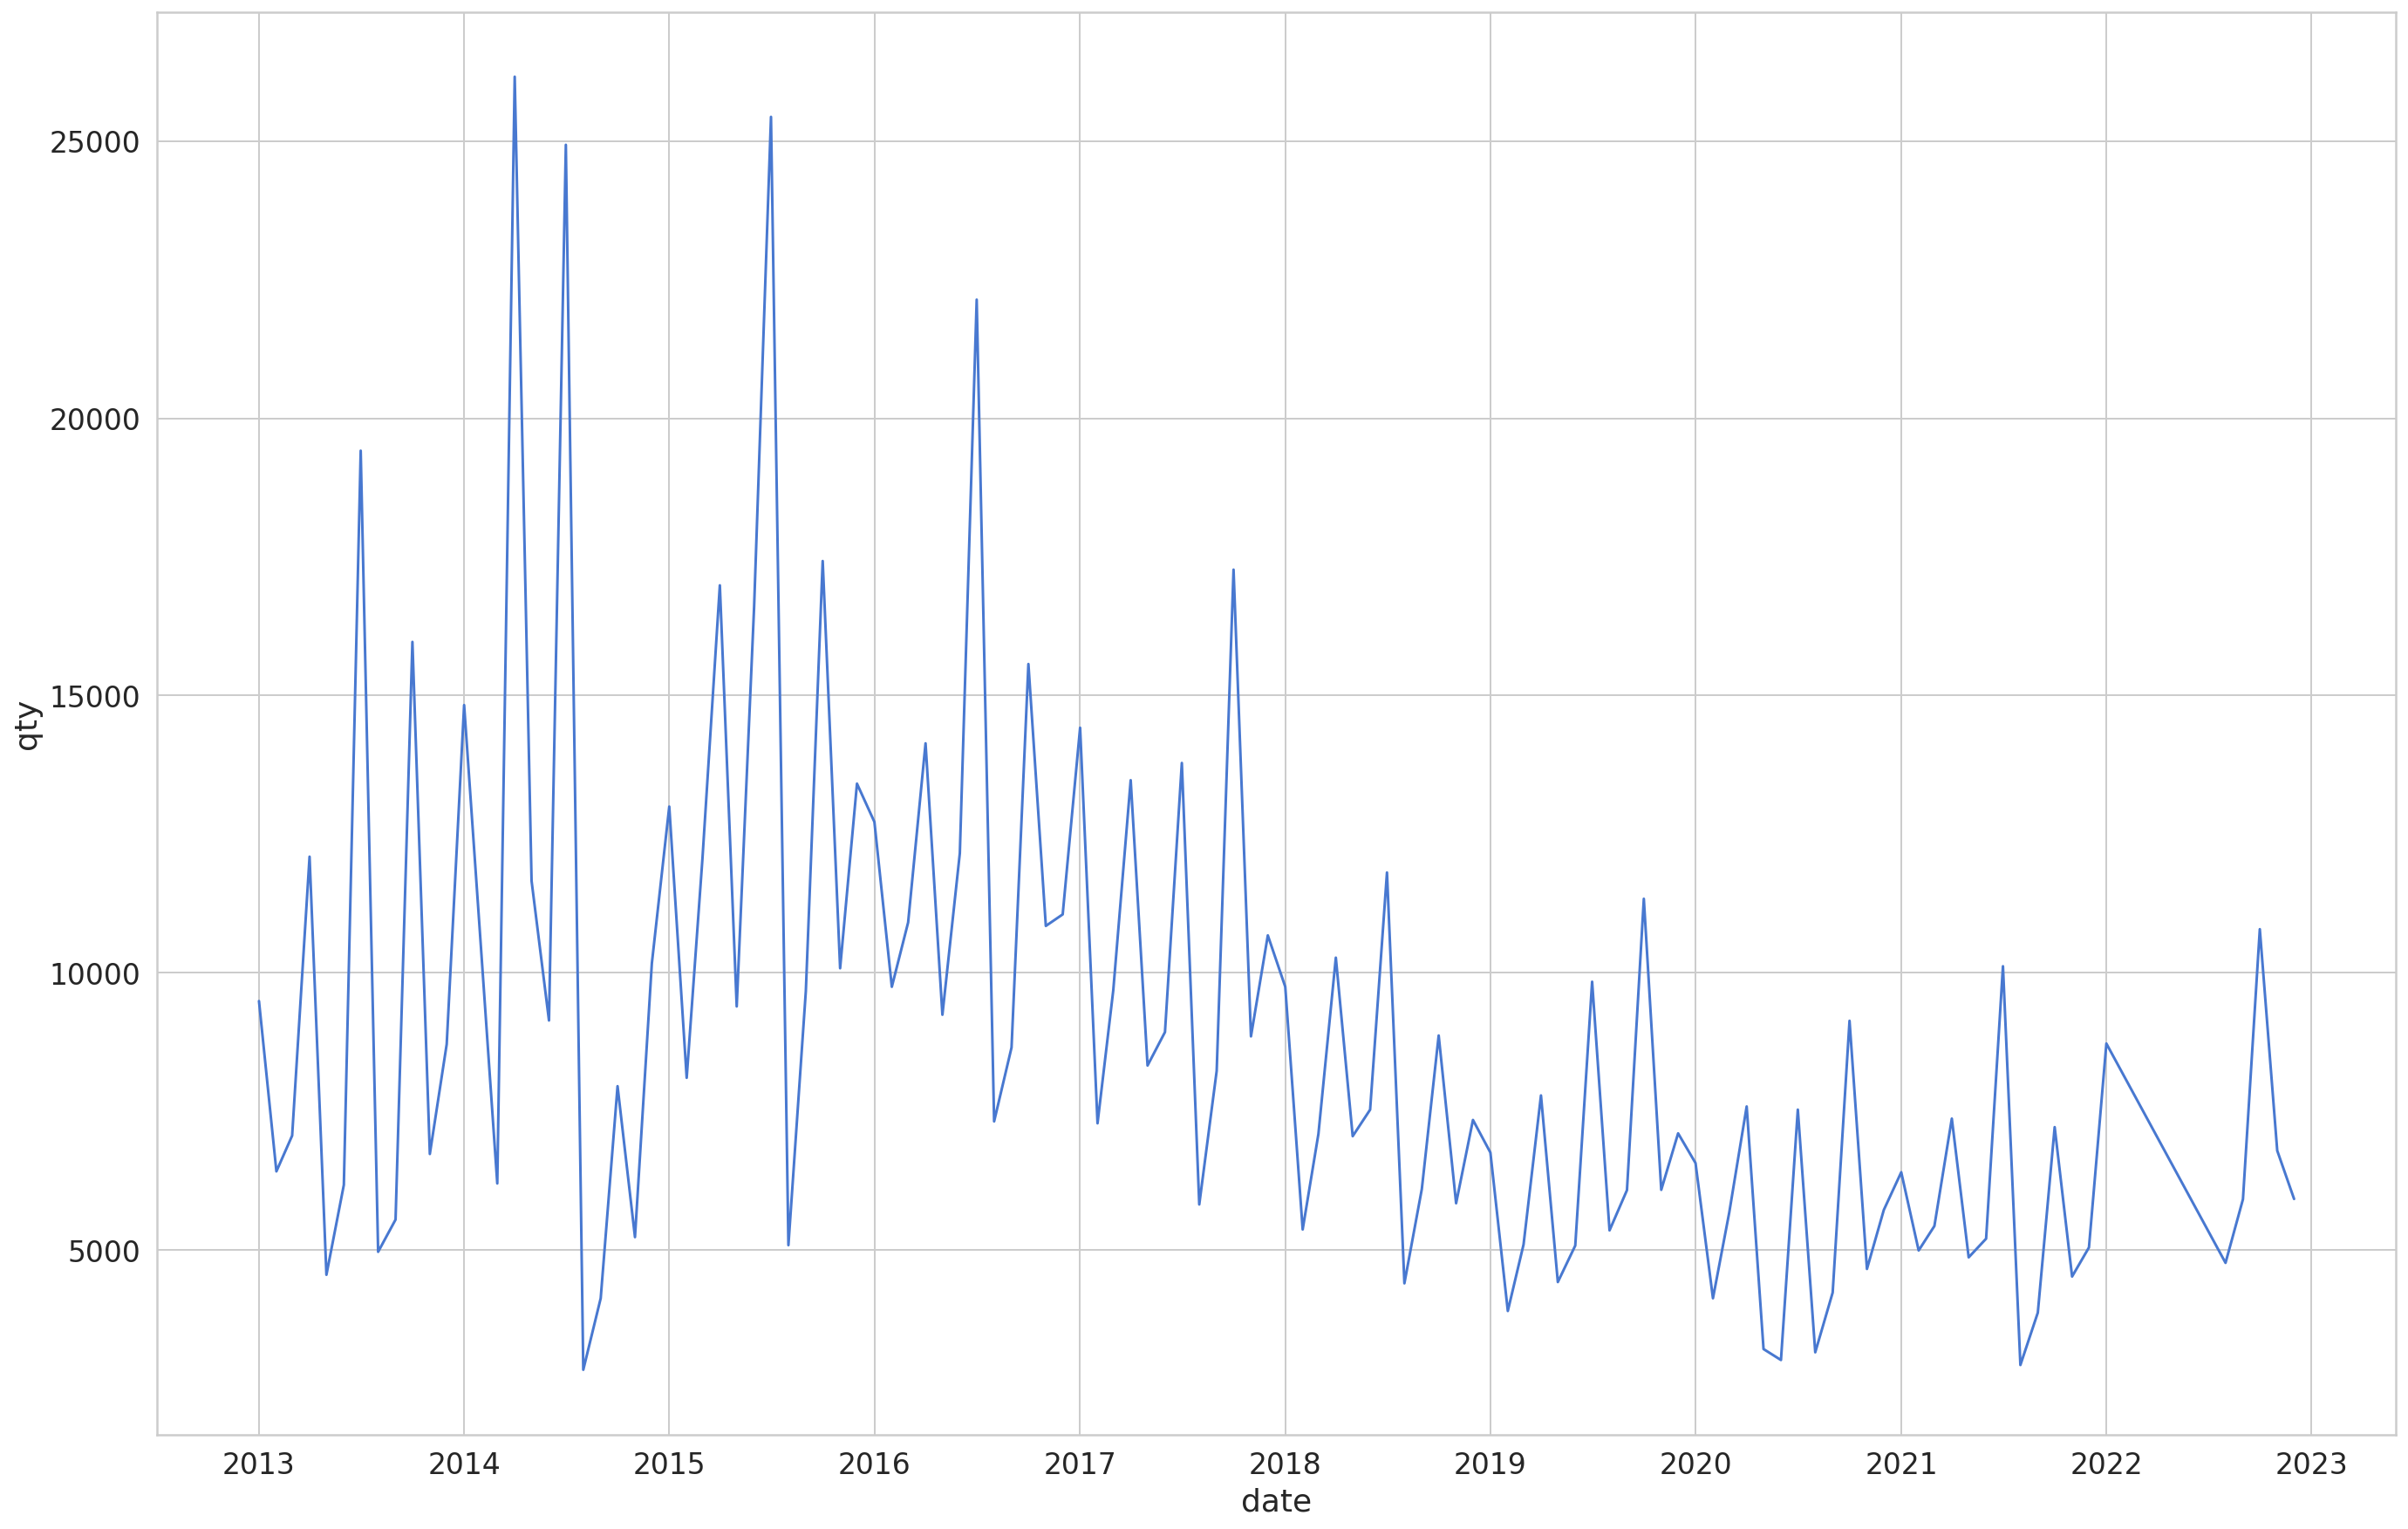

In [ ]:
p = df[["booking_date", "booked_qty"]].sort_values(by="booking_date").groupby("booking_date")["booked_qty"].mean()
p = p.reset_index()
p.columns = ["date", "qty"]

p.head()


sns.lineplot(x=p["date"], y="qty", data=p)